In [1]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math

from NN_utils import BigTable, WeightClip

print("started")

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps-1))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

# def spread_to_pr(sp, comps=1):
#     return numpy.power((1/(1+numpy.exp(-sp))), comps)

Using TensorFlow backend.


started


In [2]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform((-5), (5), size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors))
    
    minb=-(test_w/2) - d50 - a0
    maxb=(test_w/2) - d50 - a0
    questions = questions - minb - 5
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
                
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
            
    return students, questions

def gen_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
#             zmask = (questions[mi] < 0.001).astype(int)
            diffs = students[vi]-questions[mi]
            prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions

from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
# def generate_qs_model(qn_table, psi_table, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
# #     ob = Input(shape=(1,), name="observation")
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

#     psi_table.trainable=s_train
#     qn_table.trainable=q_train
    
#     qn_row = qn_table(qn_sel)
#     klip = Lambda(lambda q: K.clip(q,0,0.001))
#     q_masque = klip(qn_row)
    
# #     qn_row = GaussianNoise(.5)(qn_row)
#     psi_row = psi_table(psi_sel)
# #     psi_row = GaussianNoise(0.5)(psi_row)
    
#     difs = subtract([psi_row, qn_row])

    
#     Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
#     Prs = Lambda(lambda ps_q:  ps_q[0]*1000*ps_q[1] + (1-1000*ps_q[1]) ) ([Prs, q_masque])
# #     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0], ps_q[1]) ) ([Prs, q_masque])
#     score = Lambda(lambda ps: K.prod(ps, keepdims=True, axis=1), name="score")(Prs)
        
# # score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
# #     score = Prs
    
# #     L_2a = Lambda(lambda w: K.mean(K.abs(K.zeros_like(w)-w)))
# #     mag_loss = (L_2a(qn_table.kernel) + sumstack)
    
# #     five_limit = Lambda(lambda w: K.mean(K.clip(K.sum(K.clip(w,0,1), axis=1),5,math.inf)-5))
# #     one_limit = Lambda(lambda w: K.mean(1-K.clip(K.max(w,axis=1),0,1)))
    
# #     L_2 = Lambda(lambda w: K.mean(K.square(w - 6 )))
# #     mag_loss = L_2(psi_table.kernel)
    
# #     shift_loss = Lambda(lambda k: K.mean(k))(psi_table.kernel)
    
# #     five_loss = five_limit(qn_table.kernel)
# #     one_loss = one_limit(qn_table.kernel)
# # #     mag_loss = L_2a(qn_table.kernel) + five_limit(qn_table.kernel) + one_limit(qn_table.kernel)*5
# #     mag_loss = L_2a(qn_table.kernel) #+ five_loss + one_loss
# # #     mag_loss = L_2(qn_row)
    
# #     def ident_loss(outer):
# #         def inner(t,h):
# #             return outer
# #         return inner

# #     def custom_loss(mag_loss):
# #         def orig_loss(yt,yh):
# # #             return K.binary_crossentropy(yt,yh) + mag_loss/100000 #+mag_loss # (reg_loss+mag_loss)/2
# # #             if comp_lims:
# #             return K.mean(K.square(yt-yh)) + mag_loss #+mag_loss # (reg_loss+mag_loss)/2
# # #                 return K.binary_crossentropy(yt,yh)
# # #             else:
# # # #                 return K.mean(K.square(yt-yh))
# # #                 return K.binary_crossentropy(yt,yh)
# #         return orig_loss
    
#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
# #     model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
#     print(model.summary())
#     return model



# def generate_emb_model(qn_emb, psi_emb, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     qn_row = qn_emb(qn_sel)
#     psi_row = psi_emb(psi_sel)
# #     q_masque = q_gates(qn_sel)
    
# #     klip = Lambda(lambda q: K.clip(q,0,1e-3))
# #     q_masque = klip(qn_row)
#     difs = subtract([psi_row, qn_row])
#     Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
# #     Prs = Lambda(lambda ps_q:  ps_q[0]*1e3*ps_q[1] + (1-1e3*ps_q[1]) ) ([Prs, q_masque])
# #     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0],ps_q[1])) ([Prs, q_masque])
#     score = Lambda(lambda ps: K.prod(ps, keepdims=False, axis=2), name="score")(Prs)

#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
# #     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
#     print(model.summary())
#     return model


In [3]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
from keras.models import load_model
from keras import Input, Model
from keras.layers import Lambda, subtract, concatenate
from keras.callbacks import EarlyStopping

def generate_qs_model(qn_table, psi_table, optimiser, binary_obs=True):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    psi_row = psi_table(psi_sel)
    qn_row = qn_table(qn_sel)
    
    klip = Lambda(lambda qk: 10*(K.clip(qk,-5, -4.9)+5))
    q_masque = klip(qn_row)

    difs = subtract([psi_row, qn_row])
    Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    
#     def custom_loss(aux_loss, aux_av, aux_std, lasso):
#         def orig_loss(yt,yh):
#             return K.binary_crossentropy(yt,yh) #+ aux_loss/10000000 #+ 1000*aux_std + aux_loss/10000
# #             return K.mean(K.square(yt-yh)) + 5000*aux_av + 1000*aux_std + aux_loss/10000
#         return orig_loss
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)
    if binary_obs:
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
    else:
        model.compile(optimizer=optimiser, loss="mean_squared_error", metrics=["accuracy"])
    print(model.summary())
    return model

In [4]:
def generate_params(max_active, min_active):    
    s_avg_intel = 0
#     s_avg_intel = numpy.random.uniform(-2, 2, size=1)  
    q_av_c = (min_active + max_active)/2
    cprod_offset = pr_to_spread(0.5, comps=q_av_c, as_A_and_D=False)
    s_sd = 1
    
#     s_approx_min = s_avg_intel - 3*s_sd        
    a0 = s_avg_intel + cprod_offset
        
#     test_w = numpy.random.uniform(0.5, 4)
#     test_centre = q_active_min + test_w/2
#     print("base",base)
#     a0 = offset + base
    test_w = 5
#     test_w = numpy.random.uniform(0.5, 4)
    return s_sd,a0,q_av_c,cprod_offset,test_w

In [5]:
n_factors = 10
# wz = m.get_weights()
# s_table =  BigTable((n_students, n_factors), 6, 100, init_hilo=10)#, regulariser=regularizers.l1(10e-6))
# qn_table = BigTable((n_questions, n_factors), 0, 100, init_hilo=10-p50)#, regulariser=regularizers.l1(10e-6))
# qm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=False, q_train=True)
# sm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=True, q_train=False)
from keras import regularizers
def generate_and_train(qz,sz,pfz, vqz,vsz,vpfz, w=n_factors, qn_av=None, qn_std=None, is_binary=True):
    weight_mode="restricted"
#     weight_mode="bayesian"
# #     numpy.random.seed(666)
    if weight_mode=="free":
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo=0.1)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo=0.1)#, regulariser=regularizers.l1(10e-6))
    elif weight_mode=="semi-free":
        s_table =  BigTable((n_students, w), -3, 3, init_hilo=0.1)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo=0.1)#, regulariser=regularizers.l1(1e-6))
    else:
        s_table =  BigTable((n_students, w), -5, 5, init_hilo=None)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -8, 0, init_hilo=None)#, regulariser=regularizers.l1(10e-6))
   
    
    m = generate_qs_model(qn_table, s_table, Adam(), binary_obs=is_binary)#, s_train=True, q_train=True)
    es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
    h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=100000, verbose=1, callbacks=[es])
    return s_table, qn_table, m, h

In [6]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts, pred_wgts, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [7]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        tx=None
    else:
#         tx = PCA(n_components=2)
        tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [8]:
def scan_and_centre(n_factors, min_active, max_active, s_range=[1,3], tw_range=[1,3], offset_range=[-4,4], step=0.1):
    widest = 0
    best_score = math.inf
    best_vals = None
    for tw in numpy.arange(tw_range[0],tw_range[-1], step):
        for a1 in numpy.arange(s_range[0],s_range[-1], step):
            for a0 in numpy.arange(offset_range[0],offset_range[-1], step):
                print(a0,a1,tw)
                _, _, students_temp, qz_temp  = gen_run(n_factors, a0, a1, min_active, max_active, test_w = tw)
                pfz=[]
                probs=numpy.zeros((len(students2), len(questions)))
                for vi in range(len(students2)):
                    for mi in range(len(questions)):
                        for _ in range(1):
                #                 zmask = (qws[mi]==-10).astype(int)
                            deltas = students2[vi]-questions[mi]
                            prs = logistic(deltas,1,0)
                            pr = numpy.prod(prs)
                #                 prs = numpy.maximum(zmask,prs)
                            sz.append(vi)
                            qz.append(mi)
                            ob = (random.random() < pr)
                            probs[vi,mi] = pr
                            pfz.append(pr)
                            
                this_mu = float(numpy.mean(pfz))
                score = abs(this_mu - 0.5)
                this_sprd = float(numpy.std(pfz))
                if score < best_score and this_sprd > widest:
                    best_score=score
                    best_vals =(a0,a1,tw)
                    widest = this_sprd
                    print("new best!", best_score, widest, best_vals)
    print(best_score, widest, best_vals)
    return best_vals
                
scan_and_centre(10,10,10)

-4.0 1.0 1.0


NameError: name 'test_w' is not defined

pred list shape (0,)
real items shape (100, 10)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


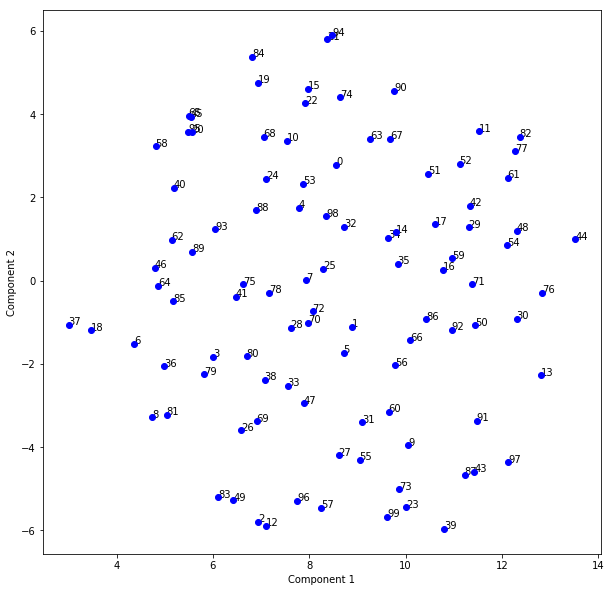

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 0 3


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


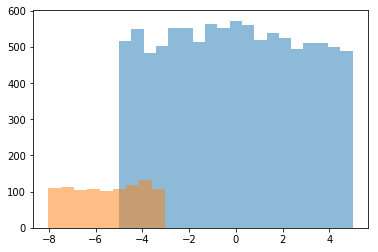

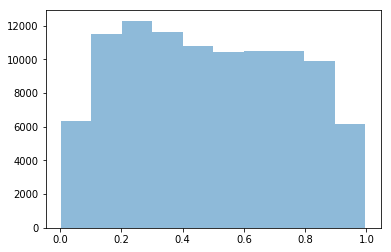

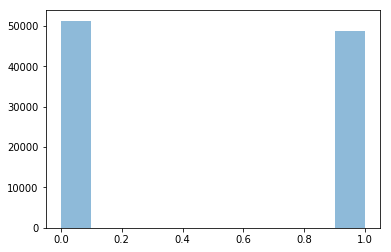

binary obs? True
Instructions for updating:
Colocations handled automatically by placer.
<NN_utils.BigTable object at 0x7f0a2b71e550> <NN_utils.BigTable object at 0x7f0a2b71ef28> Tensor("psi_select:0", shape=(?, 1), dtype=int32) Tensor("q_select:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f0a2e523940>
kk (1000, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 10)
'rows' shape, (?, 10)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f0a2ae736d8>
kk (100, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 10)
'rows' shape, (?, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         (None, 1)            0                                            
_______________________________________________________

Epoch 46/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8690 - acc: 0.5113
Epoch 47/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8674 - acc: 0.5113
Epoch 48/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8659 - acc: 0.5113
Epoch 49/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8643 - acc: 0.5113
Epoch 50/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8628 - acc: 0.5112
Epoch 51/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8612 - acc: 0.5112
Epoch 52/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8597 - acc: 0.5112
Epoch 53/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8581 - acc: 0.5112
Epoch 54/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.8566 - acc: 0.5112
Epoch 55/100000
100000/100000 [===============

100000/100000 [==============================] - 0s 1us/step - loss: 1.7542 - acc: 0.5121
Epoch 124/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7528 - acc: 0.5121
Epoch 125/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7514 - acc: 0.5121
Epoch 126/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7499 - acc: 0.5121
Epoch 127/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7485 - acc: 0.5121
Epoch 128/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7471 - acc: 0.5121
Epoch 129/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7457 - acc: 0.5122
Epoch 130/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7443 - acc: 0.5123
Epoch 131/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.7429 - acc: 0.5123
Epoch 132/100000
100000/100000 [======================

Epoch 200/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6501 - acc: 0.5136
Epoch 201/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6489 - acc: 0.5135
Epoch 202/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6476 - acc: 0.5135
Epoch 203/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6463 - acc: 0.5135
Epoch 204/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6450 - acc: 0.5135
Epoch 205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6437 - acc: 0.5135
Epoch 206/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6425 - acc: 0.5135
Epoch 207/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6412 - acc: 0.5135
Epoch 208/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.6399 - acc: 0.5135
Epoch 209/100000
100000/100000 [=====

Epoch 277/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5558 - acc: 0.5148
Epoch 278/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5547 - acc: 0.5148
Epoch 279/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5535 - acc: 0.5148
Epoch 280/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5524 - acc: 0.5148
Epoch 281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5512 - acc: 0.5147
Epoch 282/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5500 - acc: 0.5147
Epoch 283/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5489 - acc: 0.5148
Epoch 284/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5477 - acc: 0.5148
Epoch 285/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.5466 - acc: 0.5148
Epoch 286/100000
100000/100000 [=====

Epoch 354/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4703 - acc: 0.5166
Epoch 355/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4693 - acc: 0.5166
Epoch 356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4682 - acc: 0.5165
Epoch 357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4672 - acc: 0.5165
Epoch 358/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4661 - acc: 0.5164
Epoch 359/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4650 - acc: 0.5165
Epoch 360/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4640 - acc: 0.5165
Epoch 361/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4629 - acc: 0.5166
Epoch 362/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.4619 - acc: 0.5166
Epoch 363/100000
100000/100000 [=====

Epoch 431/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3927 - acc: 0.5181
Epoch 432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3917 - acc: 0.5182
Epoch 433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3908 - acc: 0.5182
Epoch 434/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3898 - acc: 0.5182
Epoch 435/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3889 - acc: 0.5182
Epoch 436/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3879 - acc: 0.5182
Epoch 437/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3870 - acc: 0.5183
Epoch 438/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3860 - acc: 0.5183
Epoch 439/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3850 - acc: 0.5182
Epoch 440/100000
100000/100000 [=====

Epoch 508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3222 - acc: 0.5202
Epoch 509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3213 - acc: 0.5201
Epoch 510/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3205 - acc: 0.5201
Epoch 511/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3196 - acc: 0.5202
Epoch 512/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3187 - acc: 0.5203
Epoch 513/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3178 - acc: 0.5203
Epoch 514/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3170 - acc: 0.5203
Epoch 515/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3161 - acc: 0.5203
Epoch 516/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.3153 - acc: 0.5203
Epoch 517/100000
100000/100000 [=====

Epoch 585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2582 - acc: 0.5227
Epoch 586/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2574 - acc: 0.5227
Epoch 587/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2566 - acc: 0.5227
Epoch 588/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2558 - acc: 0.5227
Epoch 589/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2550 - acc: 0.5227
Epoch 590/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2542 - acc: 0.5228
Epoch 591/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2534 - acc: 0.5228
Epoch 592/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2526 - acc: 0.5228
Epoch 593/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.2518 - acc: 0.5228
Epoch 594/100000
100000/100000 [=====

Epoch 662/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1999 - acc: 0.5251
Epoch 663/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1992 - acc: 0.5251
Epoch 664/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1985 - acc: 0.5251
Epoch 665/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1978 - acc: 0.5251
Epoch 666/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1971 - acc: 0.5252
Epoch 667/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1963 - acc: 0.5252
Epoch 668/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1956 - acc: 0.5252
Epoch 669/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1949 - acc: 0.5252
Epoch 670/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1942 - acc: 0.5252
Epoch 671/100000
100000/100000 [=====

Epoch 739/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1470 - acc: 0.5271
Epoch 740/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1463 - acc: 0.5271
Epoch 741/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1457 - acc: 0.5271
Epoch 742/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1450 - acc: 0.5271
Epoch 743/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1444 - acc: 0.5270
Epoch 744/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1437 - acc: 0.5271
Epoch 745/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1431 - acc: 0.5271
Epoch 746/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1424 - acc: 0.5272
Epoch 747/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.1418 - acc: 0.5272
Epoch 748/100000
100000/100000 [=====

Epoch 816/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0988 - acc: 0.5297
Epoch 817/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0982 - acc: 0.5299
Epoch 818/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0976 - acc: 0.5299
Epoch 819/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0970 - acc: 0.5299
Epoch 820/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0964 - acc: 0.5299
Epoch 821/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0958 - acc: 0.5300
Epoch 822/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0952 - acc: 0.5301
Epoch 823/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0946 - acc: 0.5300
Epoch 824/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0940 - acc: 0.5300
Epoch 825/100000
100000/100000 [=====

Epoch 893/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0549 - acc: 0.5327
Epoch 894/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0544 - acc: 0.5329
Epoch 895/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0538 - acc: 0.5329
Epoch 896/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0533 - acc: 0.5330
Epoch 897/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0527 - acc: 0.5330
Epoch 898/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0522 - acc: 0.5331
Epoch 899/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0517 - acc: 0.5331
Epoch 900/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0511 - acc: 0.5330
Epoch 901/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0506 - acc: 0.5330
Epoch 902/100000
100000/100000 [=====

Epoch 970/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0149 - acc: 0.5358
Epoch 971/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0144 - acc: 0.5358
Epoch 972/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0139 - acc: 0.5359
Epoch 973/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0134 - acc: 0.5359
Epoch 974/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0129 - acc: 0.5360
Epoch 975/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0125 - acc: 0.5360
Epoch 976/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0120 - acc: 0.5360
Epoch 977/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0115 - acc: 0.5359
Epoch 978/100000
100000/100000 [==============================] - 0s 1us/step - loss: 1.0110 - acc: 0.5360
Epoch 979/100000
100000/100000 [=====

100000/100000 [==============================] - 0s 1us/step - loss: 0.9789 - acc: 0.5393
Epoch 1047/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9785 - acc: 0.5394
Epoch 1048/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9780 - acc: 0.5394
Epoch 1049/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9776 - acc: 0.5394
Epoch 1050/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9771 - acc: 0.5394
Epoch 1051/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9766 - acc: 0.5395
Epoch 1052/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9762 - acc: 0.5395
Epoch 1053/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9758 - acc: 0.5396
Epoch 1054/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9753 - acc: 0.5396
Epoch 1055/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.9460 - acc: 0.5428
Epoch 1123/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9456 - acc: 0.5429
Epoch 1124/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9452 - acc: 0.5430
Epoch 1125/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9448 - acc: 0.5431
Epoch 1126/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9443 - acc: 0.5430
Epoch 1127/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9439 - acc: 0.5430
Epoch 1128/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9435 - acc: 0.5431
Epoch 1129/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9431 - acc: 0.5430
Epoch 1130/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9427 - acc: 0.5430
Epoch 1131/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.9159 - acc: 0.5464
Epoch 1199/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9155 - acc: 0.5465
Epoch 1200/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9151 - acc: 0.5465
Epoch 1201/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9148 - acc: 0.5466
Epoch 1202/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9144 - acc: 0.5467
Epoch 1203/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9140 - acc: 0.5468
Epoch 1204/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9136 - acc: 0.5468
Epoch 1205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9133 - acc: 0.5469
Epoch 1206/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.9129 - acc: 0.5470
Epoch 1207/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.8883 - acc: 0.5497
Epoch 1275/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8880 - acc: 0.5497
Epoch 1276/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8877 - acc: 0.5498
Epoch 1277/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8873 - acc: 0.5498
Epoch 1278/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8870 - acc: 0.5499
Epoch 1279/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8866 - acc: 0.5499
Epoch 1280/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8863 - acc: 0.5500
Epoch 1281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8859 - acc: 0.5500
Epoch 1282/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8856 - acc: 0.5501
Epoch 1283/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.8631 - acc: 0.5538
Epoch 1351/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8628 - acc: 0.5538
Epoch 1352/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8625 - acc: 0.5538
Epoch 1353/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8622 - acc: 0.5538
Epoch 1354/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8618 - acc: 0.5539
Epoch 1355/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8615 - acc: 0.5539
Epoch 1356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8612 - acc: 0.5539
Epoch 1357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8609 - acc: 0.5539
Epoch 1358/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8606 - acc: 0.5539
Epoch 1359/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.8400 - acc: 0.5581
Epoch 1427/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8397 - acc: 0.5582
Epoch 1428/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8394 - acc: 0.5582
Epoch 1429/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8391 - acc: 0.5583
Epoch 1430/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8388 - acc: 0.5583
Epoch 1431/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8385 - acc: 0.5584
Epoch 1432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8382 - acc: 0.5584
Epoch 1433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8379 - acc: 0.5585
Epoch 1434/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8376 - acc: 0.5586
Epoch 1435/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.8187 - acc: 0.5629
Epoch 1503/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8185 - acc: 0.5630
Epoch 1504/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8182 - acc: 0.5630
Epoch 1505/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8179 - acc: 0.5630
Epoch 1506/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8177 - acc: 0.5631
Epoch 1507/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8174 - acc: 0.5632
Epoch 1508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8171 - acc: 0.5632
Epoch 1509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8169 - acc: 0.5633
Epoch 1510/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.8166 - acc: 0.5634
Epoch 1511/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7992 - acc: 0.5674
Epoch 1579/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7990 - acc: 0.5675
Epoch 1580/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7987 - acc: 0.5675
Epoch 1581/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7985 - acc: 0.5676
Epoch 1582/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7982 - acc: 0.5677
Epoch 1583/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7980 - acc: 0.5677
Epoch 1584/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7978 - acc: 0.5677
Epoch 1585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7975 - acc: 0.5678
Epoch 1586/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7973 - acc: 0.5679
Epoch 1587/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7813 - acc: 0.5719
Epoch 1655/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7811 - acc: 0.5720
Epoch 1656/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7809 - acc: 0.5720
Epoch 1657/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7806 - acc: 0.5721
Epoch 1658/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7804 - acc: 0.5722
Epoch 1659/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7802 - acc: 0.5722
Epoch 1660/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7800 - acc: 0.5723
Epoch 1661/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7797 - acc: 0.5723
Epoch 1662/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7795 - acc: 0.5724
Epoch 1663/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7648 - acc: 0.5763
Epoch 1731/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7646 - acc: 0.5763
Epoch 1732/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7644 - acc: 0.5763
Epoch 1733/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7642 - acc: 0.5765
Epoch 1734/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7640 - acc: 0.5765
Epoch 1735/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7638 - acc: 0.5766
Epoch 1736/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7636 - acc: 0.5766
Epoch 1737/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7634 - acc: 0.5766
Epoch 1738/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7632 - acc: 0.5766
Epoch 1739/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7497 - acc: 0.5810
Epoch 1807/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7495 - acc: 0.5811
Epoch 1808/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7493 - acc: 0.5812
Epoch 1809/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7491 - acc: 0.5813
Epoch 1810/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7489 - acc: 0.5815
Epoch 1811/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7487 - acc: 0.5815
Epoch 1812/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7485 - acc: 0.5816
Epoch 1813/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7483 - acc: 0.5816
Epoch 1814/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7481 - acc: 0.5816
Epoch 1815/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7357 - acc: 0.5854
Epoch 1883/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7355 - acc: 0.5855
Epoch 1884/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7354 - acc: 0.5855
Epoch 1885/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7352 - acc: 0.5856
Epoch 1886/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7350 - acc: 0.5857
Epoch 1887/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7348 - acc: 0.5858
Epoch 1888/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7347 - acc: 0.5859
Epoch 1889/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7345 - acc: 0.5859
Epoch 1890/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7343 - acc: 0.5860
Epoch 1891/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7229 - acc: 0.5900
Epoch 1959/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7227 - acc: 0.5900
Epoch 1960/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7225 - acc: 0.5902
Epoch 1961/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7224 - acc: 0.5903
Epoch 1962/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7222 - acc: 0.5903
Epoch 1963/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7220 - acc: 0.5904
Epoch 1964/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7219 - acc: 0.5905
Epoch 1965/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7217 - acc: 0.5906
Epoch 1966/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7216 - acc: 0.5906
Epoch 1967/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7110 - acc: 0.5954
Epoch 2035/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7109 - acc: 0.5955
Epoch 2036/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7107 - acc: 0.5956
Epoch 2037/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7106 - acc: 0.5956
Epoch 2038/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7104 - acc: 0.5957
Epoch 2039/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7103 - acc: 0.5958
Epoch 2040/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7101 - acc: 0.5958
Epoch 2041/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7100 - acc: 0.5958
Epoch 2042/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7098 - acc: 0.5958
Epoch 2043/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.7001 - acc: 0.6001
Epoch 2111/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7000 - acc: 0.6001
Epoch 2112/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6998 - acc: 0.6001
Epoch 2113/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6997 - acc: 0.6001
Epoch 2114/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6996 - acc: 0.6002
Epoch 2115/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6994 - acc: 0.6002
Epoch 2116/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6993 - acc: 0.6003
Epoch 2117/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6992 - acc: 0.6003
Epoch 2118/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6990 - acc: 0.6004
Epoch 2119/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6901 - acc: 0.6043
Epoch 2187/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6899 - acc: 0.6044
Epoch 2188/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6898 - acc: 0.6044
Epoch 2189/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6897 - acc: 0.6045
Epoch 2190/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6896 - acc: 0.6045
Epoch 2191/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6894 - acc: 0.6045
Epoch 2192/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6893 - acc: 0.6046
Epoch 2193/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6892 - acc: 0.6047
Epoch 2194/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6891 - acc: 0.6048
Epoch 2195/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6808 - acc: 0.6090
Epoch 2263/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6807 - acc: 0.6090
Epoch 2264/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6806 - acc: 0.6091
Epoch 2265/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6805 - acc: 0.6092
Epoch 2266/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6803 - acc: 0.6093
Epoch 2267/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6802 - acc: 0.6094
Epoch 2268/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6801 - acc: 0.6094
Epoch 2269/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6800 - acc: 0.6095
Epoch 2270/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6799 - acc: 0.6096
Epoch 2271/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6723 - acc: 0.6136
Epoch 2339/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6722 - acc: 0.6137
Epoch 2340/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6721 - acc: 0.6137
Epoch 2341/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6720 - acc: 0.6138
Epoch 2342/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6718 - acc: 0.6139
Epoch 2343/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6717 - acc: 0.6140
Epoch 2344/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6716 - acc: 0.6140
Epoch 2345/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6715 - acc: 0.6141
Epoch 2346/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6714 - acc: 0.6141
Epoch 2347/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6644 - acc: 0.6182
Epoch 2415/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6643 - acc: 0.6182
Epoch 2416/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6642 - acc: 0.6183
Epoch 2417/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6641 - acc: 0.6184
Epoch 2418/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6640 - acc: 0.6184
Epoch 2419/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6639 - acc: 0.6184
Epoch 2420/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6638 - acc: 0.6185
Epoch 2421/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6637 - acc: 0.6185
Epoch 2422/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6636 - acc: 0.6186
Epoch 2423/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6572 - acc: 0.6226
Epoch 2491/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6571 - acc: 0.6228
Epoch 2492/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6570 - acc: 0.6229
Epoch 2493/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6569 - acc: 0.6229
Epoch 2494/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6568 - acc: 0.6229
Epoch 2495/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6567 - acc: 0.6229
Epoch 2496/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6566 - acc: 0.6230
Epoch 2497/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6565 - acc: 0.6230
Epoch 2498/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6564 - acc: 0.6231
Epoch 2499/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6505 - acc: 0.6268
Epoch 2567/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6504 - acc: 0.6269
Epoch 2568/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6503 - acc: 0.6270
Epoch 2569/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6502 - acc: 0.6270
Epoch 2570/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6501 - acc: 0.6270
Epoch 2571/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6500 - acc: 0.6270
Epoch 2572/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6500 - acc: 0.6271
Epoch 2573/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6499 - acc: 0.6271
Epoch 2574/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6498 - acc: 0.6273
Epoch 2575/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6443 - acc: 0.6314
Epoch 2643/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6442 - acc: 0.6315
Epoch 2644/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6441 - acc: 0.6316
Epoch 2645/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6441 - acc: 0.6317
Epoch 2646/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6440 - acc: 0.6318
Epoch 2647/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6439 - acc: 0.6319
Epoch 2648/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6438 - acc: 0.6319
Epoch 2649/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6438 - acc: 0.6320
Epoch 2650/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6437 - acc: 0.6320
Epoch 2651/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6386 - acc: 0.6355
Epoch 2719/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6385 - acc: 0.6355
Epoch 2720/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6385 - acc: 0.6356
Epoch 2721/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6384 - acc: 0.6357
Epoch 2722/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6383 - acc: 0.6357
Epoch 2723/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6383 - acc: 0.6357
Epoch 2724/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6382 - acc: 0.6358
Epoch 2725/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6381 - acc: 0.6359
Epoch 2726/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6380 - acc: 0.6359
Epoch 2727/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6334 - acc: 0.6393
Epoch 2795/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6333 - acc: 0.6395
Epoch 2796/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6332 - acc: 0.6395
Epoch 2797/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6332 - acc: 0.6396
Epoch 2798/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6331 - acc: 0.6397
Epoch 2799/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6330 - acc: 0.6397
Epoch 2800/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6330 - acc: 0.6397
Epoch 2801/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6329 - acc: 0.6398
Epoch 2802/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6328 - acc: 0.6399
Epoch 2803/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6285 - acc: 0.6435
Epoch 2871/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6285 - acc: 0.6436
Epoch 2872/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6284 - acc: 0.6436
Epoch 2873/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6283 - acc: 0.6436
Epoch 2874/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6283 - acc: 0.6437
Epoch 2875/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6282 - acc: 0.6438
Epoch 2876/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6281 - acc: 0.6438
Epoch 2877/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6281 - acc: 0.6438
Epoch 2878/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6280 - acc: 0.6439
Epoch 2879/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6240 - acc: 0.6480
Epoch 2947/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6240 - acc: 0.6480
Epoch 2948/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6239 - acc: 0.6480
Epoch 2949/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6239 - acc: 0.6481
Epoch 2950/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6238 - acc: 0.6481
Epoch 2951/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6238 - acc: 0.6481
Epoch 2952/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6237 - acc: 0.6481
Epoch 2953/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6236 - acc: 0.6482
Epoch 2954/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6236 - acc: 0.6482
Epoch 2955/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6199 - acc: 0.6515
Epoch 3023/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6198 - acc: 0.6516
Epoch 3024/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6198 - acc: 0.6517
Epoch 3025/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6197 - acc: 0.6518
Epoch 3026/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6197 - acc: 0.6518
Epoch 3027/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6196 - acc: 0.6519
Epoch 3028/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6196 - acc: 0.6519
Epoch 3029/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6195 - acc: 0.6520
Epoch 3030/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6195 - acc: 0.6520
Epoch 3031/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6161 - acc: 0.6551
Epoch 3099/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6160 - acc: 0.6551
Epoch 3100/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6160 - acc: 0.6552
Epoch 3101/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6159 - acc: 0.6553
Epoch 3102/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6159 - acc: 0.6553
Epoch 3103/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6158 - acc: 0.6553
Epoch 3104/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6158 - acc: 0.6554
Epoch 3105/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6157 - acc: 0.6554
Epoch 3106/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6157 - acc: 0.6554
Epoch 3107/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6125 - acc: 0.6584
Epoch 3175/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6125 - acc: 0.6585
Epoch 3176/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6124 - acc: 0.6586
Epoch 3177/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6124 - acc: 0.6586
Epoch 3178/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6123 - acc: 0.6587
Epoch 3179/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6123 - acc: 0.6587
Epoch 3180/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6122 - acc: 0.6588
Epoch 3181/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6122 - acc: 0.6588
Epoch 3182/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6122 - acc: 0.6589
Epoch 3183/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6092 - acc: 0.6619
Epoch 3251/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6092 - acc: 0.6620
Epoch 3252/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6091 - acc: 0.6621
Epoch 3253/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6091 - acc: 0.6621
Epoch 3254/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6091 - acc: 0.6621
Epoch 3255/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6090 - acc: 0.6621
Epoch 3256/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6090 - acc: 0.6622
Epoch 3257/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6089 - acc: 0.6622
Epoch 3258/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6089 - acc: 0.6622
Epoch 3259/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6062 - acc: 0.6644
Epoch 3327/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6061 - acc: 0.6645
Epoch 3328/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6061 - acc: 0.6645
Epoch 3329/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6061 - acc: 0.6645
Epoch 3330/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6060 - acc: 0.6646
Epoch 3331/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6060 - acc: 0.6646
Epoch 3332/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6059 - acc: 0.6647
Epoch 3333/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6059 - acc: 0.6647
Epoch 3334/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6059 - acc: 0.6647
Epoch 3335/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6033 - acc: 0.6670
Epoch 3403/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6033 - acc: 0.6670
Epoch 3404/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6033 - acc: 0.6671
Epoch 3405/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6032 - acc: 0.6671
Epoch 3406/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6032 - acc: 0.6672
Epoch 3407/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6031 - acc: 0.6672
Epoch 3408/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6031 - acc: 0.6672
Epoch 3409/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6031 - acc: 0.6673
Epoch 3410/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6030 - acc: 0.6674
Epoch 3411/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.6007 - acc: 0.6700
Epoch 3479/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6006 - acc: 0.6700
Epoch 3480/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6006 - acc: 0.6700
Epoch 3481/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6006 - acc: 0.6700
Epoch 3482/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6005 - acc: 0.6701
Epoch 3483/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6005 - acc: 0.6701
Epoch 3484/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6005 - acc: 0.6702
Epoch 3485/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6004 - acc: 0.6703
Epoch 3486/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6004 - acc: 0.6702
Epoch 3487/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5982 - acc: 0.6729
Epoch 3555/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5982 - acc: 0.6730
Epoch 3556/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5982 - acc: 0.6730
Epoch 3557/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5981 - acc: 0.6731
Epoch 3558/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5981 - acc: 0.6731
Epoch 3559/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5981 - acc: 0.6731
Epoch 3560/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5980 - acc: 0.6732
Epoch 3561/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5980 - acc: 0.6732
Epoch 3562/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5980 - acc: 0.6733
Epoch 3563/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5959 - acc: 0.6754
Epoch 3631/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5959 - acc: 0.6755
Epoch 3632/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5958 - acc: 0.6755
Epoch 3633/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5958 - acc: 0.6755
Epoch 3634/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5958 - acc: 0.6756
Epoch 3635/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5958 - acc: 0.6756
Epoch 3636/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5957 - acc: 0.6757
Epoch 3637/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5957 - acc: 0.6757
Epoch 3638/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5957 - acc: 0.6757
Epoch 3639/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5937 - acc: 0.6775
Epoch 3707/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5937 - acc: 0.6776
Epoch 3708/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5937 - acc: 0.6776
Epoch 3709/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5937 - acc: 0.6776
Epoch 3710/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5936 - acc: 0.6776
Epoch 3711/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5936 - acc: 0.6776
Epoch 3712/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5936 - acc: 0.6776
Epoch 3713/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5936 - acc: 0.6776
Epoch 3714/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5935 - acc: 0.6776
Epoch 3715/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5917 - acc: 0.6795
Epoch 3783/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5917 - acc: 0.6795
Epoch 3784/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5917 - acc: 0.6796
Epoch 3785/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5916 - acc: 0.6796
Epoch 3786/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5916 - acc: 0.6796
Epoch 3787/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5916 - acc: 0.6797
Epoch 3788/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5916 - acc: 0.6797
Epoch 3789/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5915 - acc: 0.6797
Epoch 3790/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5915 - acc: 0.6797
Epoch 3791/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5898 - acc: 0.6816
Epoch 3859/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5898 - acc: 0.6816
Epoch 3860/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6816
Epoch 3861/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6816
Epoch 3862/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6817
Epoch 3863/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6816
Epoch 3864/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6816
Epoch 3865/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6816
Epoch 3866/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6816
Epoch 3867/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5880 - acc: 0.6831
Epoch 3935/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5880 - acc: 0.6832
Epoch 3936/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5879 - acc: 0.6832
Epoch 3937/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5879 - acc: 0.6832
Epoch 3938/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5879 - acc: 0.6832
Epoch 3939/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5879 - acc: 0.6832
Epoch 3940/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5879 - acc: 0.6832
Epoch 3941/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5878 - acc: 0.6832
Epoch 3942/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5878 - acc: 0.6832
Epoch 3943/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6844
Epoch 4011/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6844
Epoch 4012/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6845
Epoch 4013/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6845
Epoch 4014/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6845
Epoch 4015/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6845
Epoch 4016/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5861 - acc: 0.6846
Epoch 4017/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5861 - acc: 0.6846
Epoch 4018/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5861 - acc: 0.6846
Epoch 4019/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5846 - acc: 0.6860
Epoch 4087/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5846 - acc: 0.6860
Epoch 4088/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5846 - acc: 0.6861
Epoch 4089/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5846 - acc: 0.6861
Epoch 4090/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5846 - acc: 0.6861
Epoch 4091/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5845 - acc: 0.6861
Epoch 4092/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5845 - acc: 0.6860
Epoch 4093/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5845 - acc: 0.6861
Epoch 4094/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5845 - acc: 0.6861
Epoch 4095/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5831 - acc: 0.6874
Epoch 4163/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5831 - acc: 0.6874
Epoch 4164/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6874
Epoch 4165/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6874
Epoch 4166/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6874
Epoch 4167/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6874
Epoch 4168/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6874
Epoch 4169/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5829 - acc: 0.6874
Epoch 4170/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5829 - acc: 0.6874
Epoch 4171/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5816 - acc: 0.6886
Epoch 4239/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5816 - acc: 0.6887
Epoch 4240/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5816 - acc: 0.6887
Epoch 4241/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6887
Epoch 4242/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6888
Epoch 4243/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6888
Epoch 4244/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6889
Epoch 4245/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6889
Epoch 4246/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5814 - acc: 0.6890
Epoch 4247/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5802 - acc: 0.6903
Epoch 4315/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5802 - acc: 0.6903
Epoch 4316/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6903
Epoch 4317/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6903
Epoch 4318/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6903
Epoch 4319/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6904
Epoch 4320/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6904
Epoch 4321/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5800 - acc: 0.6904
Epoch 4322/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5800 - acc: 0.6904
Epoch 4323/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5788 - acc: 0.6916
Epoch 4391/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5788 - acc: 0.6916
Epoch 4392/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5788 - acc: 0.6916
Epoch 4393/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6917
Epoch 4394/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6917
Epoch 4395/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6918
Epoch 4396/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6918
Epoch 4397/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6918
Epoch 4398/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5786 - acc: 0.6919
Epoch 4399/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6927
Epoch 4467/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6928
Epoch 4468/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6927
Epoch 4469/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6927
Epoch 4470/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6928
Epoch 4471/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6928
Epoch 4472/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6927
Epoch 4473/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6927
Epoch 4474/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6927
Epoch 4475/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6937
Epoch 4543/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6938
Epoch 4544/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6938
Epoch 4545/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6938
Epoch 4546/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6938
Epoch 4547/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6938
Epoch 4548/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6938
Epoch 4549/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6939
Epoch 4550/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6939
Epoch 4551/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6945
Epoch 4619/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6945
Epoch 4620/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6945
Epoch 4621/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6945
Epoch 4622/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6945
Epoch 4623/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6945
Epoch 4624/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6946
Epoch 4625/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6946
Epoch 4626/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6946
Epoch 4627/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5736 - acc: 0.6959
Epoch 4695/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5736 - acc: 0.6959
Epoch 4696/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5736 - acc: 0.6959
Epoch 4697/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5736 - acc: 0.6960
Epoch 4698/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5736 - acc: 0.6960
Epoch 4699/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5736 - acc: 0.6960
Epoch 4700/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5735 - acc: 0.6960
Epoch 4701/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5735 - acc: 0.6960
Epoch 4702/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5735 - acc: 0.6960
Epoch 4703/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5724 - acc: 0.6969
Epoch 4771/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5724 - acc: 0.6970
Epoch 4772/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5724 - acc: 0.6970
Epoch 4773/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5724 - acc: 0.6971
Epoch 4774/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5724 - acc: 0.6971
Epoch 4775/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5723 - acc: 0.6971
Epoch 4776/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5723 - acc: 0.6971
Epoch 4777/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5723 - acc: 0.6971
Epoch 4778/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5723 - acc: 0.6972
Epoch 4779/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5712 - acc: 0.6979
Epoch 4847/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5712 - acc: 0.6979
Epoch 4848/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5712 - acc: 0.6979
Epoch 4849/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5712 - acc: 0.6979
Epoch 4850/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5712 - acc: 0.6979
Epoch 4851/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5712 - acc: 0.6979
Epoch 4852/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5711 - acc: 0.6980
Epoch 4853/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5711 - acc: 0.6980
Epoch 4854/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5711 - acc: 0.6980
Epoch 4855/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5700 - acc: 0.6986
Epoch 4923/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5700 - acc: 0.6986
Epoch 4924/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5700 - acc: 0.6987
Epoch 4925/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5700 - acc: 0.6987
Epoch 4926/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5700 - acc: 0.6987
Epoch 4927/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5700 - acc: 0.6987
Epoch 4928/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5699 - acc: 0.6987
Epoch 4929/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5699 - acc: 0.6988
Epoch 4930/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5699 - acc: 0.6988
Epoch 4931/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5689 - acc: 0.6997
Epoch 4999/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5689 - acc: 0.6997
Epoch 5000/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5688 - acc: 0.6997
Epoch 5001/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5688 - acc: 0.6997
Epoch 5002/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5688 - acc: 0.6997
Epoch 5003/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5688 - acc: 0.6997
Epoch 5004/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5688 - acc: 0.6997
Epoch 5005/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5688 - acc: 0.6997
Epoch 5006/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5687 - acc: 0.6998
Epoch 5007/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5677 - acc: 0.7008
Epoch 5075/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5677 - acc: 0.7008
Epoch 5076/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5677 - acc: 0.7008
Epoch 5077/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5677 - acc: 0.7008
Epoch 5078/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5676 - acc: 0.7009
Epoch 5079/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5676 - acc: 0.7009
Epoch 5080/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5676 - acc: 0.7009
Epoch 5081/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5676 - acc: 0.7009
Epoch 5082/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5676 - acc: 0.7009
Epoch 5083/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5665 - acc: 0.7021
Epoch 5151/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5665 - acc: 0.7021
Epoch 5152/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5665 - acc: 0.7021
Epoch 5153/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5665 - acc: 0.7022
Epoch 5154/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5665 - acc: 0.7021
Epoch 5155/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5665 - acc: 0.7021
Epoch 5156/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5664 - acc: 0.7022
Epoch 5157/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5664 - acc: 0.7022
Epoch 5158/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5664 - acc: 0.7022
Epoch 5159/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5654 - acc: 0.7030
Epoch 5227/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5654 - acc: 0.7030
Epoch 5228/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5654 - acc: 0.7030
Epoch 5229/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5653 - acc: 0.7030
Epoch 5230/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5653 - acc: 0.7030
Epoch 5231/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5653 - acc: 0.7030
Epoch 5232/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5653 - acc: 0.7030
Epoch 5233/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5653 - acc: 0.7031
Epoch 5234/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5653 - acc: 0.7031
Epoch 5235/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5642 - acc: 0.7040
Epoch 5303/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5642 - acc: 0.7040
Epoch 5304/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5642 - acc: 0.7041
Epoch 5305/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5642 - acc: 0.7041
Epoch 5306/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5642 - acc: 0.7041
Epoch 5307/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5641 - acc: 0.7042
Epoch 5308/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5641 - acc: 0.7042
Epoch 5309/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5641 - acc: 0.7042
Epoch 5310/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5641 - acc: 0.7042
Epoch 5311/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5631 - acc: 0.7045
Epoch 5379/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5631 - acc: 0.7045
Epoch 5380/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5630 - acc: 0.7046
Epoch 5381/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5630 - acc: 0.7046
Epoch 5382/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5630 - acc: 0.7046
Epoch 5383/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5630 - acc: 0.7046
Epoch 5384/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5630 - acc: 0.7046
Epoch 5385/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5630 - acc: 0.7046
Epoch 5386/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5629 - acc: 0.7047
Epoch 5387/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5619 - acc: 0.7057
Epoch 5455/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5619 - acc: 0.7058
Epoch 5456/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5619 - acc: 0.7058
Epoch 5457/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5619 - acc: 0.7058
Epoch 5458/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5619 - acc: 0.7058
Epoch 5459/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5618 - acc: 0.7059
Epoch 5460/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5618 - acc: 0.7059
Epoch 5461/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5618 - acc: 0.7059
Epoch 5462/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5618 - acc: 0.7059
Epoch 5463/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5608 - acc: 0.7069
Epoch 5531/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5607 - acc: 0.7070
Epoch 5532/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5607 - acc: 0.7070
Epoch 5533/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5607 - acc: 0.7070
Epoch 5534/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5607 - acc: 0.7071
Epoch 5535/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5607 - acc: 0.7071
Epoch 5536/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5607 - acc: 0.7071
Epoch 5537/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5606 - acc: 0.7071
Epoch 5538/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5606 - acc: 0.7071
Epoch 5539/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5596 - acc: 0.7077
Epoch 5607/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5596 - acc: 0.7077
Epoch 5608/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5596 - acc: 0.7077
Epoch 5609/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5596 - acc: 0.7076
Epoch 5610/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5595 - acc: 0.7076
Epoch 5611/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5595 - acc: 0.7077
Epoch 5612/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5595 - acc: 0.7076
Epoch 5613/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5595 - acc: 0.7077
Epoch 5614/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5595 - acc: 0.7077
Epoch 5615/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5584 - acc: 0.7086
Epoch 5683/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5584 - acc: 0.7086
Epoch 5684/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5584 - acc: 0.7087
Epoch 5685/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5584 - acc: 0.7087
Epoch 5686/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5584 - acc: 0.7086
Epoch 5687/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5584 - acc: 0.7087
Epoch 5688/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5583 - acc: 0.7087
Epoch 5689/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5583 - acc: 0.7087
Epoch 5690/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5583 - acc: 0.7086
Epoch 5691/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5573 - acc: 0.7092
Epoch 5759/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5573 - acc: 0.7092
Epoch 5760/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5572 - acc: 0.7092
Epoch 5761/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5572 - acc: 0.7092
Epoch 5762/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5572 - acc: 0.7092
Epoch 5763/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5572 - acc: 0.7093
Epoch 5764/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5572 - acc: 0.7093
Epoch 5765/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5572 - acc: 0.7093
Epoch 5766/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5572 - acc: 0.7093
Epoch 5767/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5561 - acc: 0.7102
Epoch 5835/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5561 - acc: 0.7102
Epoch 5836/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5561 - acc: 0.7102
Epoch 5837/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5561 - acc: 0.7102
Epoch 5838/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5561 - acc: 0.7103
Epoch 5839/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5560 - acc: 0.7103
Epoch 5840/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5560 - acc: 0.7103
Epoch 5841/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5560 - acc: 0.7103
Epoch 5842/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5560 - acc: 0.7104
Epoch 5843/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5550 - acc: 0.7114
Epoch 5911/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5549 - acc: 0.7114
Epoch 5912/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5549 - acc: 0.7114
Epoch 5913/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5549 - acc: 0.7113
Epoch 5914/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5549 - acc: 0.7114
Epoch 5915/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5549 - acc: 0.7114
Epoch 5916/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5549 - acc: 0.7115
Epoch 5917/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5549 - acc: 0.7115
Epoch 5918/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5548 - acc: 0.7115
Epoch 5919/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5538 - acc: 0.7128
Epoch 5987/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5538 - acc: 0.7127
Epoch 5988/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5538 - acc: 0.7128
Epoch 5989/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5538 - acc: 0.7128
Epoch 5990/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5537 - acc: 0.7128
Epoch 5991/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5537 - acc: 0.7128
Epoch 5992/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5537 - acc: 0.7128
Epoch 5993/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5537 - acc: 0.7129
Epoch 5994/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5537 - acc: 0.7129
Epoch 5995/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5527 - acc: 0.7138
Epoch 6063/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5526 - acc: 0.7139
Epoch 6064/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5526 - acc: 0.7139
Epoch 6065/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5526 - acc: 0.7139
Epoch 6066/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5526 - acc: 0.7139
Epoch 6067/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5526 - acc: 0.7139
Epoch 6068/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5526 - acc: 0.7139
Epoch 6069/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5525 - acc: 0.7139
Epoch 6070/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5525 - acc: 0.7139
Epoch 6071/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5515 - acc: 0.7150
Epoch 6139/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5515 - acc: 0.7150
Epoch 6140/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5515 - acc: 0.7151
Epoch 6141/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5515 - acc: 0.7151
Epoch 6142/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5514 - acc: 0.7150
Epoch 6143/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5514 - acc: 0.7150
Epoch 6144/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5514 - acc: 0.7150
Epoch 6145/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5514 - acc: 0.7150
Epoch 6146/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5514 - acc: 0.7150
Epoch 6147/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5504 - acc: 0.7156
Epoch 6215/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5503 - acc: 0.7156
Epoch 6216/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5503 - acc: 0.7156
Epoch 6217/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5503 - acc: 0.7156
Epoch 6218/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5503 - acc: 0.7156
Epoch 6219/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5503 - acc: 0.7156
Epoch 6220/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5503 - acc: 0.7156
Epoch 6221/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5503 - acc: 0.7155
Epoch 6222/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5502 - acc: 0.7155
Epoch 6223/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5492 - acc: 0.7166
Epoch 6291/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5492 - acc: 0.7167
Epoch 6292/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5492 - acc: 0.7167
Epoch 6293/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5492 - acc: 0.7167
Epoch 6294/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5492 - acc: 0.7167
Epoch 6295/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5492 - acc: 0.7167
Epoch 6296/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5491 - acc: 0.7167
Epoch 6297/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5491 - acc: 0.7167
Epoch 6298/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5491 - acc: 0.7167
Epoch 6299/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5481 - acc: 0.7177
Epoch 6367/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5481 - acc: 0.7177
Epoch 6368/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5481 - acc: 0.7177
Epoch 6369/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5481 - acc: 0.7177
Epoch 6370/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5480 - acc: 0.7177
Epoch 6371/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5480 - acc: 0.7177
Epoch 6372/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5480 - acc: 0.7178
Epoch 6373/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5480 - acc: 0.7177
Epoch 6374/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5480 - acc: 0.7177
Epoch 6375/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5470 - acc: 0.7184
Epoch 6443/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5470 - acc: 0.7184
Epoch 6444/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5470 - acc: 0.7184
Epoch 6445/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5469 - acc: 0.7184
Epoch 6446/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5469 - acc: 0.7183
Epoch 6447/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5469 - acc: 0.7184
Epoch 6448/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5469 - acc: 0.7184
Epoch 6449/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5469 - acc: 0.7184
Epoch 6450/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5469 - acc: 0.7184
Epoch 6451/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5459 - acc: 0.7194
Epoch 6519/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5459 - acc: 0.7194
Epoch 6520/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5459 - acc: 0.7195
Epoch 6521/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5458 - acc: 0.7195
Epoch 6522/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5458 - acc: 0.7195
Epoch 6523/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5458 - acc: 0.7195
Epoch 6524/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5458 - acc: 0.7195
Epoch 6525/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5458 - acc: 0.7195
Epoch 6526/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5458 - acc: 0.7195
Epoch 6527/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5448 - acc: 0.7200
Epoch 6595/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5448 - acc: 0.7200
Epoch 6596/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5448 - acc: 0.7201
Epoch 6597/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5448 - acc: 0.7201
Epoch 6598/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5447 - acc: 0.7202
Epoch 6599/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5447 - acc: 0.7202
Epoch 6600/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5447 - acc: 0.7202
Epoch 6601/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5447 - acc: 0.7202
Epoch 6602/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5447 - acc: 0.7202
Epoch 6603/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5437 - acc: 0.7212
Epoch 6671/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5437 - acc: 0.7212
Epoch 6672/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5437 - acc: 0.7212
Epoch 6673/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5437 - acc: 0.7212
Epoch 6674/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5437 - acc: 0.7212
Epoch 6675/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5436 - acc: 0.7212
Epoch 6676/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5436 - acc: 0.7212
Epoch 6677/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5436 - acc: 0.7212
Epoch 6678/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5436 - acc: 0.7212
Epoch 6679/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5427 - acc: 0.7221
Epoch 6747/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5426 - acc: 0.7222
Epoch 6748/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5426 - acc: 0.7222
Epoch 6749/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5426 - acc: 0.7222
Epoch 6750/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5426 - acc: 0.7222
Epoch 6751/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5426 - acc: 0.7222
Epoch 6752/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5426 - acc: 0.7223
Epoch 6753/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5426 - acc: 0.7223
Epoch 6754/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5425 - acc: 0.7223
Epoch 6755/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5416 - acc: 0.7229
Epoch 6823/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5416 - acc: 0.7229
Epoch 6824/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5416 - acc: 0.7230
Epoch 6825/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5416 - acc: 0.7230
Epoch 6826/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5416 - acc: 0.7230
Epoch 6827/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5415 - acc: 0.7230
Epoch 6828/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5415 - acc: 0.7230
Epoch 6829/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5415 - acc: 0.7230
Epoch 6830/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5415 - acc: 0.7231
Epoch 6831/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5406 - acc: 0.7239
Epoch 6899/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5406 - acc: 0.7239
Epoch 6900/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5405 - acc: 0.7239
Epoch 6901/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5405 - acc: 0.7240
Epoch 6902/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5405 - acc: 0.7240
Epoch 6903/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5405 - acc: 0.7240
Epoch 6904/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5405 - acc: 0.7240
Epoch 6905/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5405 - acc: 0.7240
Epoch 6906/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5405 - acc: 0.7241
Epoch 6907/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5396 - acc: 0.7248
Epoch 6975/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7248
Epoch 6976/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7249
Epoch 6977/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7249
Epoch 6978/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7249
Epoch 6979/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7250
Epoch 6980/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7250
Epoch 6981/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7250
Epoch 6982/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5394 - acc: 0.7250
Epoch 6983/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5386 - acc: 0.7261
Epoch 7051/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5385 - acc: 0.7261
Epoch 7052/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5385 - acc: 0.7261
Epoch 7053/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5385 - acc: 0.7261
Epoch 7054/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5385 - acc: 0.7261
Epoch 7055/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5385 - acc: 0.7261
Epoch 7056/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5385 - acc: 0.7261
Epoch 7057/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5385 - acc: 0.7260
Epoch 7058/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5384 - acc: 0.7260
Epoch 7059/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5376 - acc: 0.7266
Epoch 7127/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5376 - acc: 0.7266
Epoch 7128/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5375 - acc: 0.7266
Epoch 7129/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5375 - acc: 0.7266
Epoch 7130/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5375 - acc: 0.7267
Epoch 7131/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5375 - acc: 0.7267
Epoch 7132/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5375 - acc: 0.7267
Epoch 7133/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5375 - acc: 0.7267
Epoch 7134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5375 - acc: 0.7267
Epoch 7135/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5366 - acc: 0.7276
Epoch 7203/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5366 - acc: 0.7276
Epoch 7204/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5366 - acc: 0.7276
Epoch 7205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5366 - acc: 0.7275
Epoch 7206/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5365 - acc: 0.7275
Epoch 7207/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5365 - acc: 0.7275
Epoch 7208/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5365 - acc: 0.7275
Epoch 7209/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5365 - acc: 0.7276
Epoch 7210/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5365 - acc: 0.7276
Epoch 7211/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5356 - acc: 0.7279
Epoch 7279/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5356 - acc: 0.7279
Epoch 7280/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5356 - acc: 0.7280
Epoch 7281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5356 - acc: 0.7280
Epoch 7282/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5356 - acc: 0.7280
Epoch 7283/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5356 - acc: 0.7280
Epoch 7284/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5356 - acc: 0.7280
Epoch 7285/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5355 - acc: 0.7280
Epoch 7286/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5355 - acc: 0.7280
Epoch 7287/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5347 - acc: 0.7286
Epoch 7355/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5347 - acc: 0.7286
Epoch 7356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5347 - acc: 0.7286
Epoch 7357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5346 - acc: 0.7287
Epoch 7358/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5346 - acc: 0.7286
Epoch 7359/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5346 - acc: 0.7286
Epoch 7360/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5346 - acc: 0.7286
Epoch 7361/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5346 - acc: 0.7286
Epoch 7362/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5346 - acc: 0.7287
Epoch 7363/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5338 - acc: 0.7293
Epoch 7431/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7293
Epoch 7432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7293
Epoch 7433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7293
Epoch 7434/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7293
Epoch 7435/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7292
Epoch 7436/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7293
Epoch 7437/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7293
Epoch 7438/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.7293
Epoch 7439/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5328 - acc: 0.7297
Epoch 7507/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5328 - acc: 0.7297
Epoch 7508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5328 - acc: 0.7296
Epoch 7509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5328 - acc: 0.7296
Epoch 7510/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5328 - acc: 0.7296
Epoch 7511/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5328 - acc: 0.7296
Epoch 7512/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5328 - acc: 0.7296
Epoch 7513/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5327 - acc: 0.7296
Epoch 7514/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5327 - acc: 0.7296
Epoch 7515/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5319 - acc: 0.7301
Epoch 7583/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5319 - acc: 0.7302
Epoch 7584/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5319 - acc: 0.7302
Epoch 7585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5319 - acc: 0.7302
Epoch 7586/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5319 - acc: 0.7302
Epoch 7587/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5319 - acc: 0.7302
Epoch 7588/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5318 - acc: 0.7302
Epoch 7589/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5318 - acc: 0.7302
Epoch 7590/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5318 - acc: 0.7302
Epoch 7591/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5310 - acc: 0.7307
Epoch 7659/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5310 - acc: 0.7307
Epoch 7660/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5310 - acc: 0.7307
Epoch 7661/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5310 - acc: 0.7308
Epoch 7662/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5310 - acc: 0.7308
Epoch 7663/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5310 - acc: 0.7308
Epoch 7664/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5309 - acc: 0.7308
Epoch 7665/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5309 - acc: 0.7308
Epoch 7666/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5309 - acc: 0.7308
Epoch 7667/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7310
Epoch 7735/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7310
Epoch 7736/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7309
Epoch 7737/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7310
Epoch 7738/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7309
Epoch 7739/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7309
Epoch 7740/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7310
Epoch 7741/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5301 - acc: 0.7310
Epoch 7742/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5300 - acc: 0.7311
Epoch 7743/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5293 - acc: 0.7315
Epoch 7811/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7315
Epoch 7812/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7315
Epoch 7813/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7315
Epoch 7814/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7315
Epoch 7815/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7316
Epoch 7816/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7316
Epoch 7817/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7315
Epoch 7818/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5292 - acc: 0.7316
Epoch 7819/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5284 - acc: 0.7322
Epoch 7887/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5284 - acc: 0.7322
Epoch 7888/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5284 - acc: 0.7322
Epoch 7889/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5284 - acc: 0.7322
Epoch 7890/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5283 - acc: 0.7322
Epoch 7891/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5283 - acc: 0.7322
Epoch 7892/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5283 - acc: 0.7322
Epoch 7893/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5283 - acc: 0.7322
Epoch 7894/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5283 - acc: 0.7322
Epoch 7895/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7328
Epoch 7963/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7328
Epoch 7964/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7329
Epoch 7965/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7329
Epoch 7966/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7329
Epoch 7967/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7329
Epoch 7968/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7329
Epoch 7969/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5275 - acc: 0.7328
Epoch 7970/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5274 - acc: 0.7329
Epoch 7971/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5267 - acc: 0.7336
Epoch 8039/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5267 - acc: 0.7336
Epoch 8040/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5267 - acc: 0.7336
Epoch 8041/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5267 - acc: 0.7337
Epoch 8042/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5266 - acc: 0.7337
Epoch 8043/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5266 - acc: 0.7337
Epoch 8044/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5266 - acc: 0.7337
Epoch 8045/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5266 - acc: 0.7337
Epoch 8046/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5266 - acc: 0.7338
Epoch 8047/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5259 - acc: 0.7341
Epoch 8115/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7341
Epoch 8116/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7341
Epoch 8117/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7341
Epoch 8118/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7341
Epoch 8119/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7341
Epoch 8120/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7341
Epoch 8121/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7341
Epoch 8122/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5258 - acc: 0.7342
Epoch 8123/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7348
Epoch 8191/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7348
Epoch 8192/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7348
Epoch 8193/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7348
Epoch 8194/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7349
Epoch 8195/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7349
Epoch 8196/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7349
Epoch 8197/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5250 - acc: 0.7350
Epoch 8198/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5249 - acc: 0.7350
Epoch 8199/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5242 - acc: 0.7354
Epoch 8267/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5242 - acc: 0.7354
Epoch 8268/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5242 - acc: 0.7354
Epoch 8269/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5242 - acc: 0.7354
Epoch 8270/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5242 - acc: 0.7354
Epoch 8271/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5242 - acc: 0.7354
Epoch 8272/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5242 - acc: 0.7354
Epoch 8273/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5241 - acc: 0.7354
Epoch 8274/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5241 - acc: 0.7354
Epoch 8275/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5234 - acc: 0.7359
Epoch 8343/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5234 - acc: 0.7359
Epoch 8344/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5234 - acc: 0.7359
Epoch 8345/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5234 - acc: 0.7359
Epoch 8346/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5234 - acc: 0.7359
Epoch 8347/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5234 - acc: 0.7359
Epoch 8348/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5234 - acc: 0.7359
Epoch 8349/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5233 - acc: 0.7359
Epoch 8350/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5233 - acc: 0.7360
Epoch 8351/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7366
Epoch 8419/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7366
Epoch 8420/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7367
Epoch 8421/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7367
Epoch 8422/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7367
Epoch 8423/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7367
Epoch 8424/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7367
Epoch 8425/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5226 - acc: 0.7367
Epoch 8426/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5225 - acc: 0.7367
Epoch 8427/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5219 - acc: 0.7368
Epoch 8495/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7368
Epoch 8496/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7368
Epoch 8497/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7368
Epoch 8498/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7368
Epoch 8499/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7367
Epoch 8500/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7368
Epoch 8501/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7368
Epoch 8502/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5218 - acc: 0.7368
Epoch 8503/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5211 - acc: 0.7373
Epoch 8571/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5211 - acc: 0.7373
Epoch 8572/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5211 - acc: 0.7373
Epoch 8573/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5211 - acc: 0.7373
Epoch 8574/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5210 - acc: 0.7373
Epoch 8575/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5210 - acc: 0.7373
Epoch 8576/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5210 - acc: 0.7373
Epoch 8577/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5210 - acc: 0.7373
Epoch 8578/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5210 - acc: 0.7373
Epoch 8579/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7383
Epoch 8647/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7383
Epoch 8648/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7383
Epoch 8649/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7383
Epoch 8650/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7383
Epoch 8651/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7384
Epoch 8652/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7384
Epoch 8653/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7384
Epoch 8654/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5203 - acc: 0.7384
Epoch 8655/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5196 - acc: 0.7394
Epoch 8723/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5196 - acc: 0.7394
Epoch 8724/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5196 - acc: 0.7394
Epoch 8725/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5196 - acc: 0.7394
Epoch 8726/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5195 - acc: 0.7395
Epoch 8727/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5195 - acc: 0.7394
Epoch 8728/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5195 - acc: 0.7395
Epoch 8729/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5195 - acc: 0.7395
Epoch 8730/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5195 - acc: 0.7395
Epoch 8731/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5189 - acc: 0.7401
Epoch 8799/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8800/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8801/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8802/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8803/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8804/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8805/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8806/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5188 - acc: 0.7401
Epoch 8807/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7408
Epoch 8875/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7407
Epoch 8876/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7408
Epoch 8877/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7408
Epoch 8878/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7408
Epoch 8879/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7408
Epoch 8880/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7408
Epoch 8881/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5181 - acc: 0.7408
Epoch 8882/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5180 - acc: 0.7408
Epoch 8883/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5174 - acc: 0.7414
Epoch 8951/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5174 - acc: 0.7414
Epoch 8952/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5174 - acc: 0.7413
Epoch 8953/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5174 - acc: 0.7413
Epoch 8954/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5174 - acc: 0.7413
Epoch 8955/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5174 - acc: 0.7413
Epoch 8956/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5174 - acc: 0.7413
Epoch 8957/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5173 - acc: 0.7414
Epoch 8958/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5173 - acc: 0.7414
Epoch 8959/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5167 - acc: 0.7416
Epoch 9027/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5167 - acc: 0.7417
Epoch 9028/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5167 - acc: 0.7417
Epoch 9029/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5167 - acc: 0.7416
Epoch 9030/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5167 - acc: 0.7416
Epoch 9031/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5167 - acc: 0.7417
Epoch 9032/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5166 - acc: 0.7417
Epoch 9033/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5166 - acc: 0.7417
Epoch 9034/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5166 - acc: 0.7417
Epoch 9035/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5160 - acc: 0.7421
Epoch 9103/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5160 - acc: 0.7421
Epoch 9104/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5160 - acc: 0.7421
Epoch 9105/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5160 - acc: 0.7422
Epoch 9106/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5160 - acc: 0.7422
Epoch 9107/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5159 - acc: 0.7422
Epoch 9108/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5159 - acc: 0.7422
Epoch 9109/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5159 - acc: 0.7422
Epoch 9110/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5159 - acc: 0.7423
Epoch 9111/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5153 - acc: 0.7425
Epoch 9179/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5153 - acc: 0.7426
Epoch 9180/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5153 - acc: 0.7426
Epoch 9181/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5153 - acc: 0.7426
Epoch 9182/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5153 - acc: 0.7426
Epoch 9183/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5153 - acc: 0.7426
Epoch 9184/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5152 - acc: 0.7426
Epoch 9185/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5152 - acc: 0.7426
Epoch 9186/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5152 - acc: 0.7426
Epoch 9187/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7430
Epoch 9255/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7430
Epoch 9256/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7430
Epoch 9257/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7430
Epoch 9258/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7430
Epoch 9259/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7430
Epoch 9260/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7430
Epoch 9261/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5146 - acc: 0.7431
Epoch 9262/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5145 - acc: 0.7431
Epoch 9263/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9331/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9332/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9333/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9334/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9335/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9336/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9337/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9338/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5139 - acc: 0.7434
Epoch 9339/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5133 - acc: 0.7440
Epoch 9407/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5133 - acc: 0.7440
Epoch 9408/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5133 - acc: 0.7440
Epoch 9409/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5133 - acc: 0.7441
Epoch 9410/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5132 - acc: 0.7441
Epoch 9411/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5132 - acc: 0.7441
Epoch 9412/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5132 - acc: 0.7441
Epoch 9413/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5132 - acc: 0.7441
Epoch 9414/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5132 - acc: 0.7441
Epoch 9415/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7445
Epoch 9483/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7444
Epoch 9484/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7445
Epoch 9485/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7445
Epoch 9486/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7445
Epoch 9487/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7445
Epoch 9488/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7445
Epoch 9489/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5126 - acc: 0.7445
Epoch 9490/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5125 - acc: 0.7445
Epoch 9491/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5120 - acc: 0.7451
Epoch 9559/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7451
Epoch 9560/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7452
Epoch 9561/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7452
Epoch 9562/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7452
Epoch 9563/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7453
Epoch 9564/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7452
Epoch 9565/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7452
Epoch 9566/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5119 - acc: 0.7452
Epoch 9567/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5113 - acc: 0.7455
Epoch 9635/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5113 - acc: 0.7455
Epoch 9636/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5113 - acc: 0.7455
Epoch 9637/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5113 - acc: 0.7454
Epoch 9638/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5113 - acc: 0.7454
Epoch 9639/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5113 - acc: 0.7454
Epoch 9640/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5113 - acc: 0.7454
Epoch 9641/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5112 - acc: 0.7454
Epoch 9642/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5112 - acc: 0.7454
Epoch 9643/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5107 - acc: 0.7456
Epoch 9711/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5107 - acc: 0.7456
Epoch 9712/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5106 - acc: 0.7456
Epoch 9713/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5106 - acc: 0.7457
Epoch 9714/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5106 - acc: 0.7456
Epoch 9715/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5106 - acc: 0.7456
Epoch 9716/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5106 - acc: 0.7456
Epoch 9717/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5106 - acc: 0.7457
Epoch 9718/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5106 - acc: 0.7457
Epoch 9719/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9787/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9788/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9789/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7461
Epoch 9790/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9791/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9792/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9793/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9794/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5100 - acc: 0.7460
Epoch 9795/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5094 - acc: 0.7463
Epoch 9863/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5094 - acc: 0.7463
Epoch 9864/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5094 - acc: 0.7464
Epoch 9865/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5094 - acc: 0.7464
Epoch 9866/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5094 - acc: 0.7464
Epoch 9867/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5094 - acc: 0.7464
Epoch 9868/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5093 - acc: 0.7464
Epoch 9869/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5093 - acc: 0.7464
Epoch 9870/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5093 - acc: 0.7464
Epoch 9871/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5088 - acc: 0.7468
Epoch 9939/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5088 - acc: 0.7468
Epoch 9940/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5088 - acc: 0.7468
Epoch 9941/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5087 - acc: 0.7468
Epoch 9942/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5087 - acc: 0.7468
Epoch 9943/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5087 - acc: 0.7469
Epoch 9944/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5087 - acc: 0.7469
Epoch 9945/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5087 - acc: 0.7469
Epoch 9946/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5087 - acc: 0.7470
Epoch 9947/100000
100000/100000 [=============

Epoch 10014/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7476
Epoch 10015/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7476
Epoch 10016/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7476
Epoch 10017/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7477
Epoch 10018/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7477
Epoch 10019/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7477
Epoch 10020/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7477
Epoch 10021/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7477
Epoch 10022/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5081 - acc: 0.7477
Epoch 10023/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7478
Epoch 10090/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7478
Epoch 10091/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7479
Epoch 10092/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7479
Epoch 10093/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7479
Epoch 10094/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7479
Epoch 10095/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7478
Epoch 10096/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7479
Epoch 10097/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5075 - acc: 0.7479
Epoch 10098/100000
100000/100000 [====

Epoch 10165/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10166/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10167/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10168/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10169/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10170/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7487
Epoch 10171/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10172/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10173/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5069 - acc: 0.7486
Epoch 10174/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.5064 - acc: 0.7493
Epoch 10241/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7494
Epoch 10242/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7493
Epoch 10243/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7494
Epoch 10244/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7494
Epoch 10245/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7493
Epoch 10246/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7493
Epoch 10247/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7494
Epoch 10248/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5063 - acc: 0.7494
Epoch 10249/100000
100000/100000 [====

Epoch 10316/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5058 - acc: 0.7493
Epoch 10317/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5058 - acc: 0.7493
Epoch 10318/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5058 - acc: 0.7493
Epoch 10319/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5057 - acc: 0.7493
Epoch 10320/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5057 - acc: 0.7493
Epoch 10321/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5057 - acc: 0.7493
Epoch 10322/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5057 - acc: 0.7493
Epoch 10323/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5057 - acc: 0.7494
Epoch 10324/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5057 - acc: 0.7494
Epoch 10325/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.5052 - acc: 0.7497
Epoch 10392/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5052 - acc: 0.7498
Epoch 10393/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5052 - acc: 0.7497
Epoch 10394/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5052 - acc: 0.7498
Epoch 10395/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5052 - acc: 0.7498
Epoch 10396/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5052 - acc: 0.7498
Epoch 10397/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5051 - acc: 0.7498
Epoch 10398/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5051 - acc: 0.7498
Epoch 10399/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5051 - acc: 0.7498
Epoch 10400/100000
100000/100000 [====

Epoch 10467/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7502
Epoch 10468/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7502
Epoch 10469/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7502
Epoch 10470/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7502
Epoch 10471/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7501
Epoch 10472/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7501
Epoch 10473/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7502
Epoch 10474/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5046 - acc: 0.7502
Epoch 10475/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5045 - acc: 0.7502
Epoch 10476/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10543/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10544/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10545/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10546/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10547/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10548/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10549/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10550/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.7502
Epoch 10551/100000
100000/100000 [====

Epoch 10618/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5035 - acc: 0.7505
Epoch 10619/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5035 - acc: 0.7505
Epoch 10620/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5035 - acc: 0.7505
Epoch 10621/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5035 - acc: 0.7505
Epoch 10622/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5035 - acc: 0.7505
Epoch 10623/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5035 - acc: 0.7505
Epoch 10624/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5034 - acc: 0.7506
Epoch 10625/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5034 - acc: 0.7506
Epoch 10626/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5034 - acc: 0.7506
Epoch 10627/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7507
Epoch 10694/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7507
Epoch 10695/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7508
Epoch 10696/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7508
Epoch 10697/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7508
Epoch 10698/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7508
Epoch 10699/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7508
Epoch 10700/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7508
Epoch 10701/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5029 - acc: 0.7508
Epoch 10702/100000
100000/100000 [====

Epoch 10769/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10770/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10771/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10772/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10773/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10774/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10775/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10776/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5024 - acc: 0.7513
Epoch 10777/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5023 - acc: 0.7513
Epoch 10778/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.5019 - acc: 0.7515
Epoch 10845/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5019 - acc: 0.7515
Epoch 10846/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5019 - acc: 0.7515
Epoch 10847/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5019 - acc: 0.7516
Epoch 10848/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5019 - acc: 0.7516
Epoch 10849/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5018 - acc: 0.7516
Epoch 10850/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5018 - acc: 0.7515
Epoch 10851/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5018 - acc: 0.7516
Epoch 10852/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5018 - acc: 0.7516
Epoch 10853/100000
100000/100000 [====

Epoch 10920/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5014 - acc: 0.7519
Epoch 10921/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7519
Epoch 10922/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7519
Epoch 10923/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7519
Epoch 10924/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7519
Epoch 10925/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7519
Epoch 10926/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7519
Epoch 10927/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7520
Epoch 10928/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5013 - acc: 0.7520
Epoch 10929/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7524
Epoch 10996/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 10997/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 10998/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 10999/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 11000/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 11001/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 11002/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 11003/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 0.7523
Epoch 11004/100000
100000/100000 [====

Epoch 11071/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7528
Epoch 11072/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7527
Epoch 11073/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7528
Epoch 11074/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7528
Epoch 11075/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7528
Epoch 11076/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7528
Epoch 11077/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7528
Epoch 11078/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7528
Epoch 11079/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5003 - acc: 0.7527
Epoch 11080/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4999 - acc: 0.7532
Epoch 11147/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7532
Epoch 11148/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7533
Epoch 11149/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7533
Epoch 11150/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7533
Epoch 11151/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7533
Epoch 11152/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7533
Epoch 11153/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7533
Epoch 11154/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7533
Epoch 11155/100000
100000/100000 [====

Epoch 11222/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4994 - acc: 0.7535
Epoch 11223/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4994 - acc: 0.7535
Epoch 11224/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4994 - acc: 0.7535
Epoch 11225/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4993 - acc: 0.7536
Epoch 11226/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4993 - acc: 0.7535
Epoch 11227/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4993 - acc: 0.7535
Epoch 11228/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4993 - acc: 0.7535
Epoch 11229/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4993 - acc: 0.7535
Epoch 11230/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4993 - acc: 0.7535
Epoch 11231/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11298/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11299/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11300/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11301/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11302/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11303/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11304/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7537
Epoch 11305/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4989 - acc: 0.7536
Epoch 11306/100000
100000/100000 [====

Epoch 11373/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11374/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11375/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11376/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11377/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11378/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11379/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11380/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11381/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4984 - acc: 0.7537
Epoch 11382/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4980 - acc: 0.7540
Epoch 11449/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4980 - acc: 0.7540
Epoch 11450/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4980 - acc: 0.7540
Epoch 11451/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4980 - acc: 0.7540
Epoch 11452/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4980 - acc: 0.7540
Epoch 11453/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4980 - acc: 0.7541
Epoch 11454/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4980 - acc: 0.7541
Epoch 11455/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4979 - acc: 0.7541
Epoch 11456/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4979 - acc: 0.7541
Epoch 11457/100000
100000/100000 [====

Epoch 11524/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7546
Epoch 11525/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7546
Epoch 11526/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7546
Epoch 11527/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7545
Epoch 11528/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7546
Epoch 11529/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7546
Epoch 11530/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7545
Epoch 11531/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7545
Epoch 11532/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4975 - acc: 0.7545
Epoch 11533/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7551
Epoch 11600/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7551
Epoch 11601/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7551
Epoch 11602/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7551
Epoch 11603/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7551
Epoch 11604/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7552
Epoch 11605/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7552
Epoch 11606/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7552
Epoch 11607/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4971 - acc: 0.7552
Epoch 11608/100000
100000/100000 [====

Epoch 11675/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7554
Epoch 11676/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7554
Epoch 11677/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7553
Epoch 11678/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7553
Epoch 11679/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7553
Epoch 11680/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7553
Epoch 11681/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7554
Epoch 11682/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7553
Epoch 11683/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4967 - acc: 0.7554
Epoch 11684/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11751/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11752/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7553
Epoch 11753/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11754/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11755/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11756/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11757/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11758/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 0.7554
Epoch 11759/100000
100000/100000 [====

Epoch 11826/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7555
Epoch 11827/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7555
Epoch 11828/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7556
Epoch 11829/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7556
Epoch 11830/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7555
Epoch 11831/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7555
Epoch 11832/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7555
Epoch 11833/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7555
Epoch 11834/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4959 - acc: 0.7555
Epoch 11835/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11902/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11903/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11904/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11905/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11906/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11907/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11908/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7559
Epoch 11909/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4955 - acc: 0.7560
Epoch 11910/100000
100000/100000 [====

Epoch 11977/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7563
Epoch 11978/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7563
Epoch 11979/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7563
Epoch 11980/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7563
Epoch 11981/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7564
Epoch 11982/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7564
Epoch 11983/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7564
Epoch 11984/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7564
Epoch 11985/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4951 - acc: 0.7565
Epoch 11986/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12053/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12054/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12055/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12056/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12057/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7570
Epoch 12058/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12059/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12060/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 0.7571
Epoch 12061/100000
100000/100000 [====

Epoch 12128/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12129/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12130/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12131/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12132/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12133/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7573
Epoch 12136/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4944 - acc: 0.7574
Epoch 12137/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12204/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12206/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12207/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12208/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12209/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12210/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12211/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4941 - acc: 0.7574
Epoch 12212/100000
100000/100000 [====

Epoch 12279/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4938 - acc: 0.7578
Epoch 12280/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4938 - acc: 0.7577
Epoch 12281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4938 - acc: 0.7577
Epoch 12282/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4938 - acc: 0.7578
Epoch 12283/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4938 - acc: 0.7578
Epoch 12284/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4937 - acc: 0.7578
Epoch 12285/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4937 - acc: 0.7578
Epoch 12286/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4937 - acc: 0.7578
Epoch 12287/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4937 - acc: 0.7578
Epoch 12288/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7579
Epoch 12355/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7579
Epoch 12356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7578
Epoch 12357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7578
Epoch 12358/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7578
Epoch 12359/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7578
Epoch 12360/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7578
Epoch 12361/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7578
Epoch 12362/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4934 - acc: 0.7578
Epoch 12363/100000
100000/100000 [====

Epoch 12430/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7578
Epoch 12431/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7578
Epoch 12432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7578
Epoch 12433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7578
Epoch 12434/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7578
Epoch 12435/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7579
Epoch 12436/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7579
Epoch 12437/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7579
Epoch 12438/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4931 - acc: 0.7579
Epoch 12439/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7580
Epoch 12506/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7579
Epoch 12507/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7579
Epoch 12508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7579
Epoch 12509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7579
Epoch 12510/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7579
Epoch 12511/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7579
Epoch 12512/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7580
Epoch 12513/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4928 - acc: 0.7579
Epoch 12514/100000
100000/100000 [====

Epoch 12581/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7582
Epoch 12582/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7582
Epoch 12583/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7583
Epoch 12584/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7583
Epoch 12585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7583
Epoch 12586/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7583
Epoch 12587/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7583
Epoch 12588/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7583
Epoch 12589/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4925 - acc: 0.7584
Epoch 12590/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12657/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12658/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12659/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12660/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12661/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12662/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12663/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12664/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4922 - acc: 0.7588
Epoch 12665/100000
100000/100000 [====

Epoch 12732/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7589
Epoch 12733/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7590
Epoch 12734/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7590
Epoch 12735/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7590
Epoch 12736/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7590
Epoch 12737/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7590
Epoch 12738/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7591
Epoch 12739/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7590
Epoch 12740/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4919 - acc: 0.7590
Epoch 12741/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4917 - acc: 0.7592
Epoch 12808/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4917 - acc: 0.7592
Epoch 12809/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4917 - acc: 0.7592
Epoch 12810/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4917 - acc: 0.7592
Epoch 12811/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4916 - acc: 0.7593
Epoch 12812/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4916 - acc: 0.7592
Epoch 12813/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4916 - acc: 0.7593
Epoch 12814/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4916 - acc: 0.7593
Epoch 12815/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4916 - acc: 0.7593
Epoch 12816/100000
100000/100000 [====

Epoch 12883/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12884/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12885/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12886/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12887/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12888/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12889/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12890/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12891/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4914 - acc: 0.7595
Epoch 12892/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12959/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12960/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12961/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12962/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12963/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12964/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12965/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12966/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4911 - acc: 0.7599
Epoch 12967/100000
100000/100000 [====

Epoch 13034/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4909 - acc: 0.7601
Epoch 13035/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4909 - acc: 0.7601
Epoch 13036/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4909 - acc: 0.7601
Epoch 13037/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4909 - acc: 0.7601
Epoch 13038/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4908 - acc: 0.7601
Epoch 13039/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4908 - acc: 0.7601
Epoch 13040/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4908 - acc: 0.7600
Epoch 13041/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4908 - acc: 0.7600
Epoch 13042/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4908 - acc: 0.7601
Epoch 13043/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7600
Epoch 13110/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7600
Epoch 13111/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7599
Epoch 13112/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7599
Epoch 13113/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7599
Epoch 13114/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7599
Epoch 13115/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7599
Epoch 13116/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7599
Epoch 13117/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4906 - acc: 0.7599
Epoch 13118/100000
100000/100000 [====

Epoch 13185/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4904 - acc: 0.7602
Epoch 13186/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4904 - acc: 0.7602
Epoch 13187/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4904 - acc: 0.7602
Epoch 13188/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4903 - acc: 0.7602
Epoch 13189/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4903 - acc: 0.7602
Epoch 13190/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4903 - acc: 0.7601
Epoch 13191/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4903 - acc: 0.7601
Epoch 13192/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4903 - acc: 0.7601
Epoch 13193/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4903 - acc: 0.7601
Epoch 13194/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13261/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13262/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13263/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13264/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13265/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13266/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13267/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13268/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4901 - acc: 0.7602
Epoch 13269/100000
100000/100000 [====

Epoch 13336/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13337/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13338/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13339/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13340/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13341/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13342/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13343/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13344/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4899 - acc: 0.7600
Epoch 13345/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4897 - acc: 0.7603
Epoch 13412/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4897 - acc: 0.7603
Epoch 13413/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4896 - acc: 0.7603
Epoch 13414/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4896 - acc: 0.7603
Epoch 13415/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4896 - acc: 0.7602
Epoch 13416/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4896 - acc: 0.7603
Epoch 13417/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4896 - acc: 0.7603
Epoch 13418/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4896 - acc: 0.7603
Epoch 13419/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4896 - acc: 0.7602
Epoch 13420/100000
100000/100000 [====

Epoch 13487/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7607
Epoch 13488/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7606
Epoch 13489/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7606
Epoch 13490/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7606
Epoch 13491/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7607
Epoch 13492/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7607
Epoch 13493/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7606
Epoch 13494/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7606
Epoch 13495/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4894 - acc: 0.7606
Epoch 13496/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7607
Epoch 13563/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7607
Epoch 13564/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7607
Epoch 13565/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7607
Epoch 13566/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7607
Epoch 13567/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7607
Epoch 13568/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7608
Epoch 13569/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7608
Epoch 13570/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4892 - acc: 0.7608
Epoch 13571/100000
100000/100000 [====

Epoch 13638/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13639/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13640/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13641/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13642/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13643/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7612
Epoch 13644/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13645/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13646/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4890 - acc: 0.7611
Epoch 13647/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7612
Epoch 13714/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7612
Epoch 13715/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7613
Epoch 13716/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7613
Epoch 13717/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7613
Epoch 13718/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7612
Epoch 13719/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7612
Epoch 13720/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7613
Epoch 13721/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 0.7613
Epoch 13722/100000
100000/100000 [====

Epoch 13789/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7613
Epoch 13790/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7613
Epoch 13791/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7613
Epoch 13792/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7613
Epoch 13793/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7612
Epoch 13794/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7612
Epoch 13795/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7613
Epoch 13796/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7613
Epoch 13797/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4886 - acc: 0.7613
Epoch 13798/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7613
Epoch 13865/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7613
Epoch 13866/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7613
Epoch 13867/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7613
Epoch 13868/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7613
Epoch 13869/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7613
Epoch 13870/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7612
Epoch 13871/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7612
Epoch 13872/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4884 - acc: 0.7612
Epoch 13873/100000
100000/100000 [====

Epoch 13940/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13941/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13942/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13943/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13944/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13945/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13946/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13947/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13948/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4883 - acc: 0.7612
Epoch 13949/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14016/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14017/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14018/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14019/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14020/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14021/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14022/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14023/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4881 - acc: 0.7613
Epoch 14024/100000
100000/100000 [====

Epoch 14091/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14092/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14093/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14094/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14095/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14096/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14097/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14098/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14099/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4879 - acc: 0.7612
Epoch 14100/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7614
Epoch 14167/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7615
Epoch 14168/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7615
Epoch 14169/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7615
Epoch 14170/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7615
Epoch 14171/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7614
Epoch 14172/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7614
Epoch 14173/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7614
Epoch 14174/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4878 - acc: 0.7614
Epoch 14175/100000
100000/100000 [====

Epoch 14242/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14243/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14244/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14245/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14246/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14247/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14248/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14249/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14250/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4876 - acc: 0.7615
Epoch 14251/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14318/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14319/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14320/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14321/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14322/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14323/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14324/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14325/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4875 - acc: 0.7617
Epoch 14326/100000
100000/100000 [====

Epoch 14393/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7618
Epoch 14394/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7618
Epoch 14395/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7618
Epoch 14396/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7617
Epoch 14397/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7617
Epoch 14398/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7618
Epoch 14399/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7618
Epoch 14400/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7618
Epoch 14401/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4873 - acc: 0.7618
Epoch 14402/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14469/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14470/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14471/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14472/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14473/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14474/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14475/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14476/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4872 - acc: 0.7618
Epoch 14477/100000
100000/100000 [====

Epoch 14544/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14545/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14546/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14547/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14548/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14549/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14550/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14551/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14552/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4871 - acc: 0.7619
Epoch 14553/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7621
Epoch 14620/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7621
Epoch 14621/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7621
Epoch 14622/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7622
Epoch 14623/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7622
Epoch 14624/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7622
Epoch 14625/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7622
Epoch 14626/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7622
Epoch 14627/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.7622
Epoch 14628/100000
100000/100000 [====

Epoch 14695/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7621
Epoch 14696/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7621
Epoch 14697/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7621
Epoch 14698/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7621
Epoch 14699/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7621
Epoch 14700/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7621
Epoch 14701/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7621
Epoch 14702/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7622
Epoch 14703/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4868 - acc: 0.7622
Epoch 14704/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14771/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14772/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14773/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14774/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14775/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14776/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14777/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14778/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4867 - acc: 0.7622
Epoch 14779/100000
100000/100000 [====

Epoch 14846/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7622
Epoch 14847/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7623
Epoch 14848/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7623
Epoch 14849/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7622
Epoch 14850/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7622
Epoch 14851/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7622
Epoch 14852/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7622
Epoch 14853/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7622
Epoch 14854/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.7622
Epoch 14855/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14922/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7621
Epoch 14923/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14924/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14925/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14926/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14927/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14928/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14929/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4865 - acc: 0.7622
Epoch 14930/100000
100000/100000 [====

Epoch 14997/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 14998/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 14999/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 15000/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 15001/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 15002/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 15003/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 15004/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 15005/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4864 - acc: 0.7623
Epoch 15006/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4863 - acc: 0.7624
Epoch 15073/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4863 - acc: 0.7624
Epoch 15074/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4863 - acc: 0.7624
Epoch 15075/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4863 - acc: 0.7624
Epoch 15076/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4863 - acc: 0.7624
Epoch 15077/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4863 - acc: 0.7624
Epoch 15078/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4862 - acc: 0.7624
Epoch 15079/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4862 - acc: 0.7624
Epoch 15080/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4862 - acc: 0.7624
Epoch 15081/100000
100000/100000 [====

Epoch 15148/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4862 - acc: 0.7625
Epoch 15149/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4862 - acc: 0.7626
Epoch 15150/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4862 - acc: 0.7626
Epoch 15151/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7626
Epoch 15152/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7626
Epoch 15153/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7626
Epoch 15154/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7626
Epoch 15155/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7626
Epoch 15156/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7625
Epoch 15157/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7628
Epoch 15224/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7628
Epoch 15225/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4861 - acc: 0.7629
Epoch 15226/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15227/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15228/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15229/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15230/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15231/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15232/100000
100000/100000 [====

Epoch 15299/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15300/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7629
Epoch 15301/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7628
Epoch 15302/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7628
Epoch 15303/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7628
Epoch 15304/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4860 - acc: 0.7628
Epoch 15305/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7628
Epoch 15306/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7628
Epoch 15307/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7629
Epoch 15308/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15375/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15376/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15377/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15378/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15379/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15380/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15381/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7627
Epoch 15382/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 0.7626
Epoch 15383/100000
100000/100000 [====

Epoch 15450/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15451/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15452/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15453/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15454/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15455/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15456/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15457/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15458/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.7626
Epoch 15459/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15526/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15527/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15528/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15529/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15530/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15531/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15532/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15533/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 0.7625
Epoch 15534/100000
100000/100000 [====

Epoch 15601/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15602/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15603/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15604/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15605/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15606/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15607/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15608/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15609/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4856 - acc: 0.7625
Epoch 15610/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15677/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15678/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15679/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15680/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15681/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15682/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7624
Epoch 15683/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15684/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4855 - acc: 0.7625
Epoch 15685/100000
100000/100000 [====

Epoch 15752/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7625
Epoch 15753/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7625
Epoch 15754/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7625
Epoch 15755/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7624
Epoch 15756/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7625
Epoch 15757/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7624
Epoch 15758/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7625
Epoch 15759/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7625
Epoch 15760/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7625
Epoch 15761/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15828/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15829/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15830/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15831/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15832/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15833/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15834/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7626
Epoch 15835/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 0.7627
Epoch 15836/100000
100000/100000 [====

Epoch 15903/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15904/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15905/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15906/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15907/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15908/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15909/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15910/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15911/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 0.7626
Epoch 15912/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7627
Epoch 15979/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7627
Epoch 15980/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7627
Epoch 15981/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7627
Epoch 15982/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7627
Epoch 15983/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7627
Epoch 15984/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7628
Epoch 15985/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7628
Epoch 15986/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4852 - acc: 0.7628
Epoch 15987/100000
100000/100000 [====

Epoch 16054/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16055/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16056/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16057/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16058/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16059/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16060/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16061/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16062/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16063/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16130/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16131/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16132/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16133/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7628
Epoch 16135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7629
Epoch 16136/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7629
Epoch 16137/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4851 - acc: 0.7629
Epoch 16138/100000
100000/100000 [====

Epoch 16205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16206/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16207/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16208/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16209/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16210/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16211/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16212/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16213/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4850 - acc: 0.7628
Epoch 16214/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16282/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16283/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7626
Epoch 16284/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7626
Epoch 16285/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7626
Epoch 16286/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7626
Epoch 16287/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7626
Epoch 16288/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7626
Epoch 16289/100000
100000/100000 [====

Epoch 16356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7626
Epoch 16357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16358/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16359/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16360/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16361/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16362/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16363/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16364/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.7627
Epoch 16365/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16434/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16435/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16436/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16437/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16438/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16439/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16440/100000
100000/100000 [====

Epoch 16507/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16510/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7628
Epoch 16511/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16512/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16513/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16514/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16515/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4848 - acc: 0.7627
Epoch 16516/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16583/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16584/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16586/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16587/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16588/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16589/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16590/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4847 - acc: 0.7628
Epoch 16591/100000
100000/100000 [====

Epoch 16658/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7628
Epoch 16659/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7628
Epoch 16660/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7628
Epoch 16661/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7628
Epoch 16662/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7628
Epoch 16663/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16664/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16665/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16666/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16667/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16734/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16735/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16736/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16737/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16738/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16739/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16740/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16741/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4846 - acc: 0.7629
Epoch 16742/100000
100000/100000 [====

Epoch 16809/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16810/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16811/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16812/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16813/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16814/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16815/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16816/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16817/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7630
Epoch 16818/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16885/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16886/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16887/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16888/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16889/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16890/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16891/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16892/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4845 - acc: 0.7631
Epoch 16893/100000
100000/100000 [====

Epoch 16960/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16961/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16962/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16963/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16964/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16965/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16966/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16967/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16968/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 16969/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17036/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7632
Epoch 17037/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17038/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17039/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17040/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17041/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17042/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17043/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17044/100000
100000/100000 [====

Epoch 17111/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17112/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4844 - acc: 0.7631
Epoch 17113/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17114/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17115/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17116/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17117/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7630
Epoch 17118/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17119/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17120/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17187/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17188/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17189/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17190/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17191/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17192/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17193/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17194/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7631
Epoch 17195/100000
100000/100000 [====

Epoch 17262/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17263/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17264/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17265/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17266/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17267/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17268/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17269/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17270/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4843 - acc: 0.7629
Epoch 17271/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17338/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17339/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17340/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17341/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17342/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17343/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7629
Epoch 17344/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7629
Epoch 17345/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7629
Epoch 17346/100000
100000/100000 [====

Epoch 17413/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17414/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17415/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17416/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17417/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17418/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4842 - acc: 0.7628
Epoch 17419/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17420/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17421/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4842 - acc: 0.7628
Epoch 17422/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17489/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17490/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17491/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17492/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17493/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7627
Epoch 17494/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17495/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17496/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7627
Epoch 17497/100000
100000/100000 [====

Epoch 17564/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17565/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17566/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17567/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7628
Epoch 17568/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7629
Epoch 17569/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7629
Epoch 17570/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7629
Epoch 17571/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7629
Epoch 17572/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7629
Epoch 17573/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17640/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17641/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17642/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17643/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17644/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17645/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17646/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17647/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4841 - acc: 0.7630
Epoch 17648/100000
100000/100000 [====

Epoch 17715/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17716/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17717/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17718/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17719/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17720/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17721/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17722/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17723/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17724/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17791/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17792/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17793/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17794/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17795/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17796/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17797/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17798/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7632
Epoch 17799/100000
100000/100000 [====

Epoch 17866/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7631
Epoch 17867/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7631
Epoch 17868/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7631
Epoch 17869/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4840 - acc: 0.7631
Epoch 17870/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7631
Epoch 17871/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7631
Epoch 17872/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7631
Epoch 17873/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7631
Epoch 17874/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4840 - acc: 0.7631
Epoch 17875/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17942/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17943/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4840 - acc: 0.7630
Epoch 17944/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 17945/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7631
Epoch 17946/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 17947/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7631
Epoch 17948/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7631
Epoch 17949/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7631
Epoch 17950/100000
100000/100000 [====

Epoch 18017/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4839 - acc: 0.7630
Epoch 18018/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4839 - acc: 0.7630
Epoch 18019/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4839 - acc: 0.7630
Epoch 18020/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18021/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18022/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18023/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4839 - acc: 0.7630
Epoch 18024/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7631
Epoch 18025/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4839 - acc: 0.7631
Epoch 18026/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18093/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18094/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18095/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18096/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18097/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18098/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18099/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18100/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7630
Epoch 18101/100000
100000/100000 [====

Epoch 18168/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18169/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18170/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18171/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18172/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18173/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18174/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4839 - acc: 0.7629
Epoch 18175/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18176/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4839 - acc: 0.7629
Epoch 18177/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18244/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18245/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18246/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18247/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18248/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18249/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18250/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18251/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7629
Epoch 18252/100000
100000/100000 [====

Epoch 18319/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18320/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18321/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18322/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18323/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18324/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18325/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18326/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18327/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7631
Epoch 18328/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18395/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18396/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18397/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18398/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18399/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18400/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18401/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18402/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18403/100000
100000/100000 [====

Epoch 18470/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18471/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18472/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18473/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18474/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18475/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18476/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18477/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18478/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4838 - acc: 0.7632
Epoch 18479/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18546/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18547/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18548/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18549/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18550/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18551/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18552/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7632
Epoch 18553/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18554/100000
100000/100000 [====

Epoch 18621/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18622/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4837 - acc: 0.7631
Epoch 18623/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18624/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4837 - acc: 0.7631
Epoch 18625/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4837 - acc: 0.7631
Epoch 18626/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18627/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18628/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4837 - acc: 0.7631
Epoch 18629/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4837 - acc: 0.7631
Epoch 18630/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18697/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18698/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18699/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18700/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18701/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18702/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18703/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18704/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7631
Epoch 18705/100000
100000/100000 [====

Epoch 18772/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18773/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18774/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4837 - acc: 0.7630
Epoch 18775/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18776/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18777/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18778/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18779/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18780/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4837 - acc: 0.7630
Epoch 18781/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7630
Epoch 18848/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4836 - acc: 0.7630
Epoch 18849/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7630
Epoch 18850/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4836 - acc: 0.7630
Epoch 18851/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18852/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18853/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7630
Epoch 18854/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4836 - acc: 0.7631
Epoch 18855/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18856/100000
100000/100000 [====

Epoch 18923/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18924/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18925/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18926/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18927/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18928/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18929/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18930/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18931/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18932/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 18999/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19000/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19001/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19002/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19003/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19004/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19005/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19006/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19007/100000
100000/100000 [====

Epoch 19074/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19075/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19076/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19077/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19078/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19079/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19080/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19081/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19082/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7632
Epoch 19083/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19150/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19151/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19152/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19153/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19154/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19155/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19156/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19157/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4836 - acc: 0.7631
Epoch 19158/100000
100000/100000 [====

Epoch 19225/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7631
Epoch 19226/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4835 - acc: 0.7631
Epoch 19227/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7631
Epoch 19228/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7631
Epoch 19229/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19230/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19231/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4835 - acc: 0.7632
Epoch 19232/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19233/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19234/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19301/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19302/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19303/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19304/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19305/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19306/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19307/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19308/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19309/100000
100000/100000 [====

Epoch 19376/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19377/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19378/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19379/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19380/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19381/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19382/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19383/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19384/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19385/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19452/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7632
Epoch 19453/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7633
Epoch 19454/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7633
Epoch 19455/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7633
Epoch 19456/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7633
Epoch 19457/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7633
Epoch 19458/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7633
Epoch 19459/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4835 - acc: 0.7633
Epoch 19460/100000
100000/100000 [====

Epoch 19527/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19528/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19529/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19530/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19531/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19532/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19533/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19534/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19535/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19536/100000


100000/100000 [==============================] - 0s 2us/step - loss: 0.4834 - acc: 0.7633
Epoch 19603/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19604/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19605/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19606/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19607/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19608/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19609/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4834 - acc: 0.7633
Epoch 19610/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19611/100000
100000/100000 [====

Epoch 19678/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19679/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19680/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7633
Epoch 19681/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19682/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19683/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19684/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19685/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19686/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19687/100000


100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19754/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19755/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19756/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19757/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19758/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19759/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19760/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19761/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19762/100000
100000/100000 [====

Epoch 19829/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19830/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19831/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19832/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19833/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19834/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.4834 - acc: 0.7632
Epoch 19835/100000


KeyboardInterrupt: 

In [10]:
import copy
# numpy.random.seed(666)
# n_students, n_questions, a0, a1, offset, test_w = (1000, 100, 0.8110750422323121, 1.1967074599870124, 0.53204746933021974, 2.6389781733222257)
n_students, n_questions = 1000,100
n_factors, min_active, max_active = (10,10,10)
# n_factors, min_active, max_active = (2,2,2)
# n_factors, min_active, max_active = (1,1,1)
# n_students, n_questions, a0, a1, offset, test_w = (5000, 100, 0.6516427938897171, 1.5588438755755065, 0.53204746933021974, 0.7168318678096066)

qws_list = []
sws_list = []
tr_list = []
# questions=None
stu_list=[]
n_runs = 5
tw=None
qn_av = None
qn_std = None

a0s = numpy.linspace(-2,2,n_runs)

for a in range(n_runs):
#     a1,a0,av_c,offset,test_w = generate_params(min_active, max_active)
    _,_, a0, a1, offset, test_w =(None, None, 0.8110750422323121, 2, 0.53, 1) #1.1967074599870124, 0.53204746933021974, 2.6389781733222257)

#     print(a0)
#     test_w = 4
#     a0 = 0.85

#     test_w = 5
#     a0 = 1

#     test_w = 10
#     a0 = 2.8
    
#     test_w = 6
#     a0 = 4

    if n_factors==2:
        test_w = 4
        a0 = 2
    if n_factors==10:
        test_w = 5
        a0 = 3
#         test_w = 15
#         a0 = 5.8
#         test_w = 5
        a1 = 5
#         a0 = 3
        
    if tw is None:
        tw=test_w
    
    questions=None
    
    _, _, students_temp, qz_temp  = gen_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
    stu_list.append(students_temp)
                
    if questions is None:
        students2 = students_temp
        questions = qz_temp
        qn_av = numpy.mean(questions, axis=0)
        qn_std = numpy.std(questions, axis=0)
    plot_items([], questions, None)
        
    print("~ ~ ~ ~~ ATTEMPT",a, a0)
    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
    plt.show()

#     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
#     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))

    sz=[]
    qz=[]
    pfz=[]
    probs=numpy.zeros((len(students2), len(questions)))
    for vi in range(len(students2)):
        for mi in range(len(questions)):
            for _ in range(1):
    #                 zmask = (qws[mi]==-10).astype(int)
                deltas = students2[vi]-questions[mi]
                prs = logistic(deltas,1,0)
                pr = numpy.prod(prs)
    #                 prs = numpy.maximum(zmask,prs)
                sz.append(vi)
                qz.append(mi)
                ob = (random.random() < pr)
                probs[vi,mi] = pr
                pfz.append(ob)
    
    plt.hist(probs.flatten(), alpha=0.5)
    plt.show()
    
    plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
    plt.show()

#     break
    
    vqz2,vsz2,vpfz2 = [],[],[]
    
# for runix in range(n_runs):
#     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
    obs_are_binary = numpy.array_equal(numpy.array(pfz).flatten(), numpy.array(pfz).flatten().astype(bool))
    print("binary obs?", obs_are_binary)

    s_table2, qn_table2, m2, h2 = generate_and_train(qz,sz,pfz, vqz2,vsz2,vpfz2, w=n_factors, qn_av=qn_av, qn_std=qn_std, is_binary=obs_are_binary)
    qws2= copy.copy(qn_table2.get_weights()[0])
    sws2= copy.copy(s_table2.get_weights()[0])
#     qg = q_gates.get_weights()[0]
#     qg_list.append(qg)
#     if qn_av is None:
#         qn_av = numpy.mean(qws2)

    sws_list.append(sws2)
    qws_list.append(qws2)

pred list shape (0,)
real items shape (100, 10)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


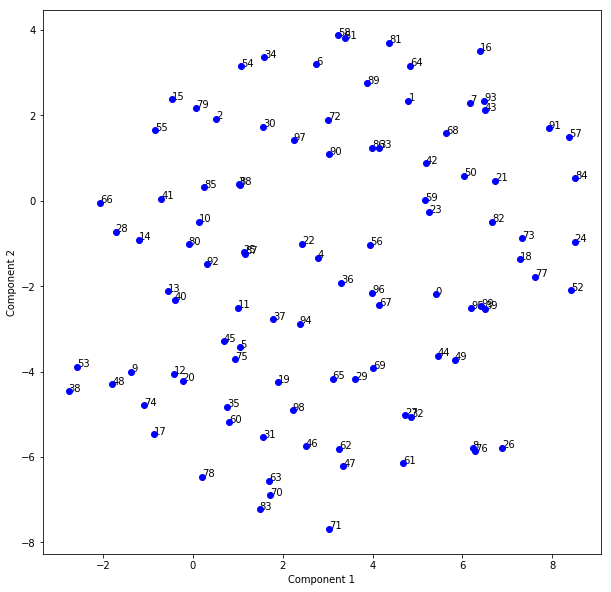

len Cs 0
Mean rand score = nan nan
pred list shape (0,)
real items shape (100, 10)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


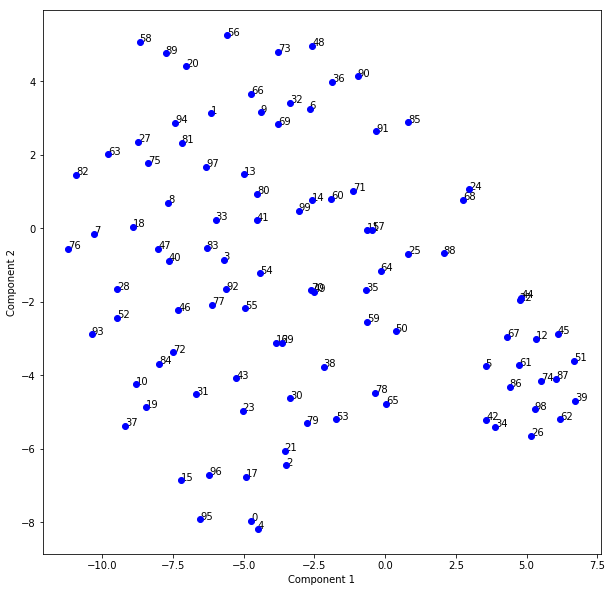

len Cs 0
Mean rand score = nan nan
pred list shape (0,)
real items shape (100, 10)


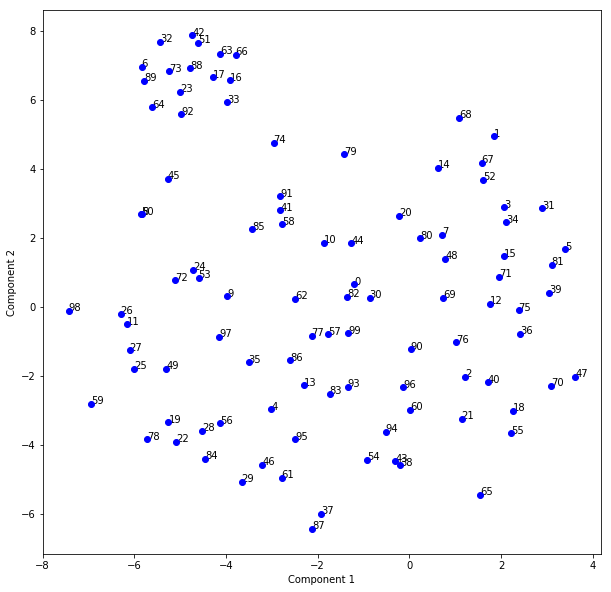

len Cs 0
Mean rand score = nan nan
pred list shape (0,)
real items shape (100, 10)


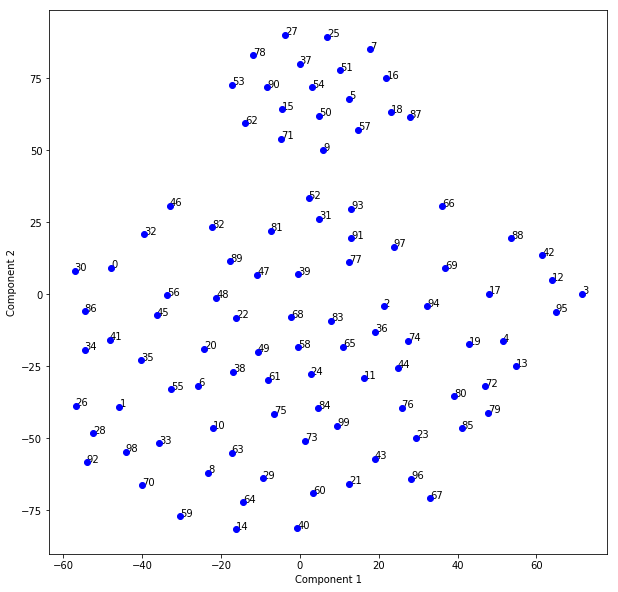

len Cs 0
Mean rand score = nan nan


In [233]:
plot_items([], questions, None)

for qns in qws_list:
    plot_items([], qns, None)

3
pred list shape (3, 100, 10)
real items shape (100, 10)
0 [[-3.84 -5.28 -6.45 -3.18 -4.71 -3.87 -5.11 -7.62 -3.09 -3.78]
 [-3.99 -5.2  -3.96 -6.56 -3.58 -4.04 -7.32 -4.83 -4.48 -6.98]
 [-4.57 -7.4  -3.68 -6.62 -7.2  -7.06 -3.49 -4.18 -5.4  -4.26]
 [-3.28 -6.18 -3.79 -3.51 -7.06 -5.98 -5.8  -3.21 -6.58 -4.38]
 [-3.05 -7.52 -6.7  -4.61 -6.98 -3.79 -5.99 -5.22 -4.51 -5.25]
 [-6.55 -6.8  -4.16 -5.72 -5.94 -3.6  -4.62 -5.9  -4.83 -6.43]
 [-4.77 -6.65 -5.53 -7.33 -4.34 -7.45 -3.86 -3.71 -4.84 -7.35]
 [-6.23 -6.14 -3.54 -6.54 -3.96 -4.95 -7.12 -7.79 -7.17 -7.61]
 [-7.45 -5.58 -7.16 -5.86 -4.7  -7.95 -4.33 -7.71 -6.22 -4.87]
 [-3.99 -4.28 -4.54 -7.63 -7.46 -3.55 -6.04 -6.69 -6.05 -4.41]
 [-5.49 -6.33 -3.63 -3.91 -6.22 -3.59 -3.42 -3.18 -5.4  -3.12]
 [-7.32 -5.69 -4.84 -5.74 -7.83 -5.07 -5.82 -4.73 -3.96 -5.46]
 [-6.2  -4.84 -4.18 -6.73 -6.67 -3.91 -5.84 -5.66 -6.11 -6.52]
 [-7.31 -4.32 -3.08 -3.49 -6.7  -3.77 -5.87 -4.82 -5.16 -4.23]
 [-6.1  -5.98 -3.72 -3.4  -7.72 -6.64 -3.54 -6.64 -4.81 -5

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[-2.95 -8.   -8.   -1.48 -1.69 -3.22 -5.99 -8.   -4.21 -3.82]
 [-4.57 -4.97 -2.33 -5.29 -1.84 -2.69 -8.   -4.25 -4.64 -8.  ]
 [-4.44 -8.   -3.5  -8.   -8.   -5.96 -3.38 -2.43 -6.1  -4.23]
 [-3.55 -8.   -3.73 -1.89 -8.   -8.   -7.8  -0.72 -6.19 -4.17]
 [-2.92 -6.82 -4.83 -2.85 -3.33 -2.89 -6.95 -4.61 -7.99 -4.54]
 [-8.   -8.   -3.4  -4.34 -3.83 -1.71 -5.34 -5.42 -5.23 -5.45]
 [-4.54 -8.   -8.   -8.   -1.89 -5.18 -3.94 -2.33 -5.78 -8.  ]
 [-8.   -5.84 -3.11 -5.34 -1.6  -5.01 -8.   -5.81 -6.59 -8.  ]
 [-8.   -5.13 -8.   -8.   -2.66 -8.   -4.4  -8.   -8.   -4.49]
 [-3.95 -3.55 -3.5  -8.   -4.56 -2.89 -6.71 -8.   -7.23 -4.93]
 [-8.   -8.   -2.89 -2.   -5.2  -1.63 -4.34 -0.99 -4.79 -3.45]
 [-4.63 -4.17 -5.25 -3.46 -8.   -3.75 -5.85 -3.69 -4.66 -8.  ]
 [-6.71 -4.31 -3.75 -8.   -3.73 -2.82 -5.44 -4.83 -6.08 -8.  ]
 [-8.   -4.4  -2.12 -2.17 -8.   -2.42 -5.94 -2.97 -4.68 -3.96]
 [-5.23 -8.   -2.74 -1.91 -4.56 -8.   -3.32 -8.   -5.24 -5.57]
 [-4.05 -8.   -2.24 -8.   -4.37 -4.56 -3.44 -8.   -8.  

[7 6 2 3 4 1 2 6 5 0 5 0 6 1 1 3 6 0 3 7 0 0 7 5 7 5 5 5 7 5 5 1 5 1 2 0 4
 0 6 0 1 1 4 6 0 7 1 7 6 7 5 2 2 6 2 7 4 1 2 4 0 7 7 1 2 5 7 4 5 0 1 0 2 5
 6 7 5 2 4 3 4 2 1 1 2 5 1 7 1 2 3 6 7 1 0 7 4 2 7 7]
X [9, 11, 17, 20, 21, 35, 37, 39, 44, 60, 69, 71, 94]
X [5, 13, 14, 31, 33, 40, 41, 46, 57, 63, 70, 82, 83, 86, 88, 93]
X [2, 6, 34, 51, 52, 54, 58, 64, 72, 77, 81, 84, 89, 97]
X [3, 15, 18, 79, 90]
X [4, 36, 42, 56, 59, 67, 78, 80, 96]
X [8, 10, 23, 25, 26, 27, 29, 30, 32, 50, 65, 68, 73, 76, 85]
X [1, 7, 12, 16, 38, 43, 48, 53, 74, 91]
X [0, 19, 22, 24, 28, 45, 47, 49, 55, 61, 62, 66, 75, 87, 92, 95, 98, 99]
<class 'numpy.ndarray'>
no pts= 100  indices= 100 200
shape of itemz_2 (400, 2)
[0 5 2 1 6 5 2 5 4 5 6 6 5 6 0 3 5 5 4 0 3 6 6 4 4 2 4 4 3 6 2 3 4 5 7 3 7
 6 7 3 1 3 5 5 4 3 6 1 7 0 4 1 7 7 7 0 0 7 4 0 6 3 1 1 5 3 0 1 5 3 6 3 2 4
 5 0 4 4 0 2 6 2 4 6 6 6 3 4 1 5 2 6 1 7 6 4 1 2 5 0]
X [0, 14, 19, 49, 55, 56, 59, 66, 75, 78, 99]
X [3, 40, 47, 51, 62, 63, 67, 88, 92, 96]
X [2, 6, 2

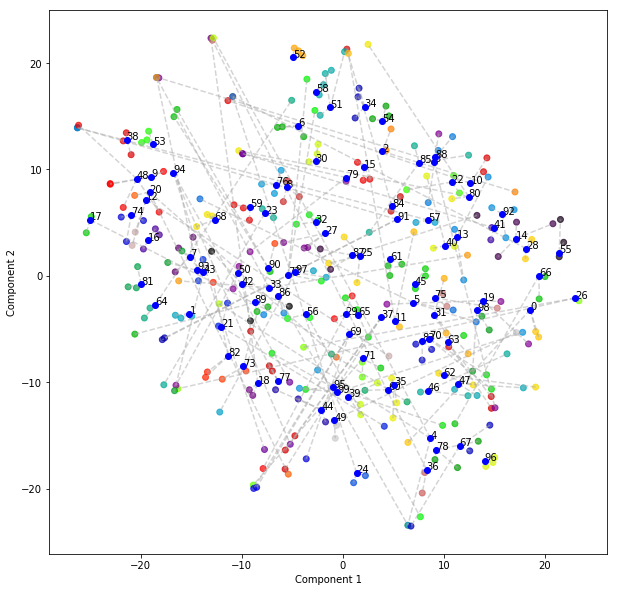

len Cs 3
Rand: 0.104899689316
Rand: 0.197126221635
Rand: 0.104899689316
Rand: 0.0848678465009
Rand: 0.197126221635
Rand: 0.0848678465009
Mean rand score = 0.128964585817 0.048886433903


In [238]:
print(len(qws_list))
plot_items(qws_list, copy.copy(questions), 0)

In [1]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in stu_list:
    plt.hist(ss.flatten(), alpha=0.5, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()


plt.hist(questions.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))
print(bin_spread(qws2))
# plt.show()

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw))
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw))

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

NameError: name 'stu_list' is not defined

In [20]:
def print_comparison(pred_list, real_items):
    for items in pred_list:
        for item, real_item in zip(items, real_items):
            print(numpy.sort(real_item))
            print(numpy.sort(item))
            print()

numpy.set_printoptions(precision=2)
print_comparison(qws_list, questions)

[-10.43  -9.59  -9.37  -9.22  -7.86  -5.63  -4.72  -4.42  -3.49  -3.03]
[-15.3  -14.16 -11.32  -6.65  -5.21  -2.22  -1.71  -1.51  -0.57  -0.43]

[-10.58 -10.21  -9.92  -8.89  -8.2   -7.89  -6.87  -6.65  -5.02  -4.51]
[-8.01 -7.36 -7.3  -6.21 -5.42 -4.86 -3.85 -3.73 -2.01 -1.63]

[-10.51  -9.78  -9.57  -9.35  -8.6   -8.25  -7.97  -5.59  -3.31  -3.3 ]
[-12.94 -12.82  -8.7   -6.97  -5.68  -5.42  -5.08  -3.    -0.64  -0.55]

[-10.68 -10.28  -9.77  -8.49  -7.83  -7.35  -7.34  -6.84  -5.53  -2.88]
[-13.83  -7.41  -7.08  -5.23  -5.06  -4.86  -4.69  -3.84  -2.66  -0.12]

[-10.33 -10.09  -9.85  -9.26  -8.69  -8.26  -6.89  -6.49  -5.81  -4.07]
[-16.27 -13.79  -7.01  -6.31  -6.01  -5.49  -4.02  -3.47  -2.89  -1.58]

[-10.73 -10.53  -8.23  -8.16  -5.7   -5.66  -4.03  -3.72  -3.02  -3.02]
[-14.37 -10.55  -5.66  -5.11  -2.7   -2.66  -1.45  -0.96  -0.54  -0.1 ]

[-10.86 -10.77 -10.08  -7.99  -6.71  -6.2   -5.96  -5.88  -5.76  -4.99]
[-8.92 -8.24 -7.66 -5.08 -3.69 -3.46 -3.3  -3.28 -2.95 -1.59]

[-10.

0 [[-3.84 -5.28 -6.45 -3.18 -4.71 -3.87 -5.11 -7.62 -3.09 -3.78]
 [-3.99 -5.2  -3.96 -6.56 -3.58 -4.04 -7.32 -4.83 -4.48 -6.98]
 [-4.57 -7.4  -3.68 -6.62 -7.2  -7.06 -3.49 -4.18 -5.4  -4.26]
 [-3.28 -6.18 -3.79 -3.51 -7.06 -5.98 -5.8  -3.21 -6.58 -4.38]
 [-3.05 -7.52 -6.7  -4.61 -6.98 -3.79 -5.99 -5.22 -4.51 -5.25]
 [-6.55 -6.8  -4.16 -5.72 -5.94 -3.6  -4.62 -5.9  -4.83 -6.43]
 [-4.77 -6.65 -5.53 -7.33 -4.34 -7.45 -3.86 -3.71 -4.84 -7.35]
 [-6.23 -6.14 -3.54 -6.54 -3.96 -4.95 -7.12 -7.79 -7.17 -7.61]
 [-7.45 -5.58 -7.16 -5.86 -4.7  -7.95 -4.33 -7.71 -6.22 -4.87]
 [-3.99 -4.28 -4.54 -7.63 -7.46 -3.55 -6.04 -6.69 -6.05 -4.41]
 [-5.49 -6.33 -3.63 -3.91 -6.22 -3.59 -3.42 -3.18 -5.4  -3.12]
 [-7.32 -5.69 -4.84 -5.74 -7.83 -5.07 -5.82 -4.73 -3.96 -5.46]
 [-6.2  -4.84 -4.18 -6.73 -6.67 -3.91 -5.84 -5.66 -6.11 -6.52]
 [-7.31 -4.32 -3.08 -3.49 -6.7  -3.77 -5.87 -4.82 -5.16 -4.23]
 [-6.1  -5.98 -3.72 -3.4  -7.72 -6.64 -3.54 -6.64 -4.81 -5.  ]
 [-3.03 -7.48 -3.93 -6.78 -6.43 -5.28 -3.67 -6.02 -7.

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[-4.63 -3.65  0.   -4.79 -8.   -8.   -8.   -8.   -3.4  -8.  ]
 [-8.   -3.3  -4.25 -5.75 -8.   -3.39 -3.83 -3.36 -3.59 -4.04]
 [-5.57 -8.   -6.35 -5.82 -2.83 -8.   -5.14 -2.88 -4.36 -3.4 ]
 [-8.   -8.   -8.    0.   -8.   -8.   -8.   -8.   -8.   -8.  ]
 [-8.   -8.   -8.   -8.   -8.   -8.   -8.   -8.    0.   -8.  ]
 [-8.   -2.03 -4.5  -6.94 -3.52 -4.29 -8.   -3.77 -8.   -5.2 ]
 [-8.   -8.   -5.38 -7.45 -3.19 -2.92 -8.   -8.   -4.22 -2.62]
 [-8.   -3.95 -7.59 -8.   -6.42 -2.96 -8.   -2.37 -8.   -8.  ]
 [-4.96 -8.   -5.21 -5.9  -4.22 -3.8  -5.48 -5.7  -8.   -8.  ]
 [-5.07 -2.1  -8.   -8.   -8.   -5.9  -3.27 -3.37 -4.05 -8.  ]
 [-3.71 -2.1  -4.77 -4.29 -3.49 -8.   -4.64 -2.98 -8.   -1.57]
 [-8.   -8.   -7.8  -8.   -8.   -8.   -8.   -8.   -8.   -0.53]
 [-7.01 -2.75 -4.61 -8.   -8.   -8.   -3.78 -3.48 -8.   -5.78]
 [-4.94 -3.1  -5.88 -3.07 -8.   -5.33 -3.94 -1.43 -8.   -5.35]
 [-6.5  -8.   -2.93 -3.16 -3.79 -8.   -6.22 -3.03 -8.   -5.98]
 [-4.1  -8.   -8.   -5.29 -2.66 -6.9  -8.   -3.38 -3.09

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


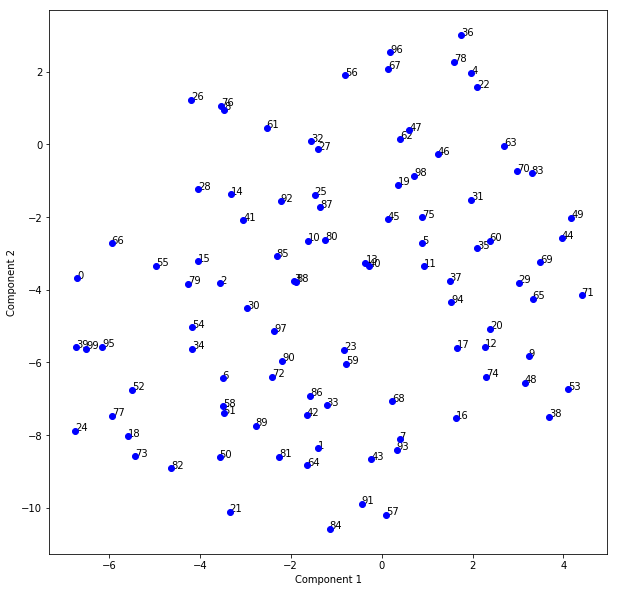

len Cs 0
Mean rand score = nan nan
pred list shape (1, 100, 10)
real items shape (100, 10)
0 [[-3.84 -5.28 -6.45 -3.18 -4.71 -3.87 -5.11 -7.62 -3.09 -3.78]
 [-3.99 -5.2  -3.96 -6.56 -3.58 -4.04 -7.32 -4.83 -4.48 -6.98]
 [-4.57 -7.4  -3.68 -6.62 -7.2  -7.06 -3.49 -4.18 -5.4  -4.26]
 [-3.28 -6.18 -3.79 -3.51 -7.06 -5.98 -5.8  -3.21 -6.58 -4.38]
 [-3.05 -7.52 -6.7  -4.61 -6.98 -3.79 -5.99 -5.22 -4.51 -5.25]
 [-6.55 -6.8  -4.16 -5.72 -5.94 -3.6  -4.62 -5.9  -4.83 -6.43]
 [-4.77 -6.65 -5.53 -7.33 -4.34 -7.45 -3.86 -3.71 -4.84 -7.35]
 [-6.23 -6.14 -3.54 -6.54 -3.96 -4.95 -7.12 -7.79 -7.17 -7.61]
 [-7.45 -5.58 -7.16 -5.86 -4.7  -7.95 -4.33 -7.71 -6.22 -4.87]
 [-3.99 -4.28 -4.54 -7.63 -7.46 -3.55 -6.04 -6.69 -6.05 -4.41]
 [-5.49 -6.33 -3.63 -3.91 -6.22 -3.59 -3.42 -3.18 -5.4  -3.12]
 [-7.32 -5.69 -4.84 -5.74 -7.83 -5.07 -5.82 -4.73 -3.96 -5.46]
 [-6.2  -4.84 -4.18 -6.73 -6.67 -3.91 -5.84 -5.66 -6.11 -6.52]
 [-7.31 -4.32 -3.08 -3.49 -6.7  -3.77 -5.87 -4.82 -5.16 -4.23]
 [-6.1  -5.98 -3.72 -3.4 

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[4 0 6 2 1 0 7 0 3 1 6 6 0 0 2 2 0 0 1 4 0 5 6 3 6 6 3 7 2 5 3 4 3 0 7 5 1
 5 1 5 6 2 3 3 5 2 4 4 1 4 3 7 7 1 6 2 2 1 7 3 5 2 4 4 7 5 2 4 3 5 4 5 7 3
 0 4 3 5 4 3 6 7 3 4 6 6 7 6 6 7 2 1 2 0 5 6 2 7 4 5]
X [1, 5, 7, 12, 13, 16, 17, 20, 33, 74, 93]
X [4, 9, 18, 36, 38, 48, 53, 57, 91]
X [3, 14, 15, 28, 41, 45, 55, 56, 61, 66, 90, 92, 96]
X [8, 23, 26, 30, 32, 42, 43, 50, 59, 68, 73, 76, 79, 82]
X [0, 19, 31, 46, 47, 49, 62, 63, 67, 70, 75, 78, 83, 98]
X [21, 29, 35, 37, 39, 44, 60, 65, 69, 71, 77, 94, 99]
X [2, 10, 11, 22, 24, 25, 40, 54, 80, 84, 85, 87, 88, 95]
X [6, 27, 34, 51, 52, 58, 64, 72, 81, 86, 89, 97]
<class 'numpy.ndarray'>
no pts= 100  indices= 100 200
shape of itemz_2 (200, 2)


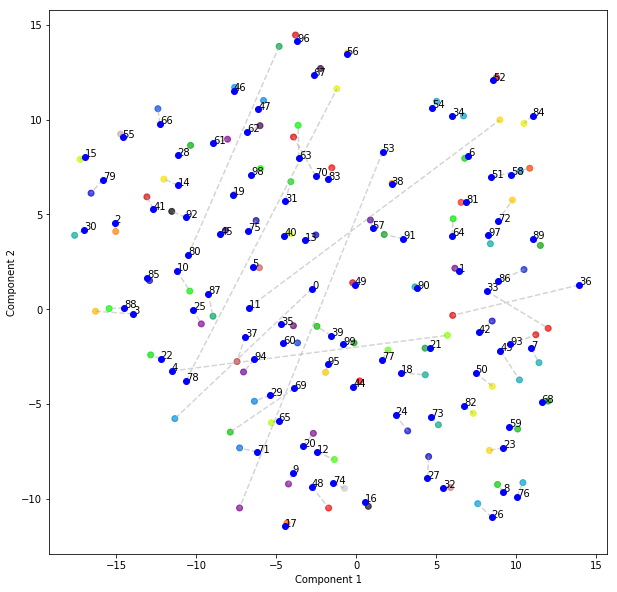

len Cs 1
Mean rand score = nan nan


In [239]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.mean(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.mean(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(questions, qws_list)
plot_items([], questions, None)
plot_items([mean_en],questions, 0)
            